## Test out how to edit on 2_Spurious_MNIST dataset

In [1]:
# General imports
import torch
import numpy as np
import os, sys
import json
from tqdm import tqdm
from datetime import datetime
import pandas as pd
import shutil

In [2]:
# Local imports
sys.path.insert(0, 'src')
from utils import read_json, read_lists, informal_log, list_to_dict, write_lists, write_json, save_image
from utils.visualizations import show_image_rows, make_grid
from utils.model_utils import prepare_device
from parse_config import ConfigParser
# from data_loader import data_loaders
import datasets.datasets as module_data
import datasets.edit_datasets as module_edit_data
import model.model as module_arch
from utils.knn_utils import load_and_analyze_knn
from utils.results_to_csv import store_csv
from edit_MNIST import edit, run_trials

In [79]:
# Define constants, paths
dataset_type = '2_Spurious_MNIST'
model_type = 'LeNet'
file_name = '2_Spurious_MNIST_LeNet_edit.json'
# config_path = os.path.join('configs', 'MNIST', '{}_{}_edit.json'.format(dataset_type, model_type))
config_path = os.path.join('configs', 'MNIST', file_name)
config_dict = read_json(config_path)
class_list = [i for i in range(10)]

analyze_in_edit = True

In [80]:
# Load config file
config = ConfigParser(config_dict)
print("Save dir: {}".format(config.save_dir))

# Set K
K = config_dict['editor']['K']

device, device_ids = prepare_device(config_dict['n_gpu'])
seed = config_dict['seed']

Save dir: saved/edit_2_Spurious_MNIST/method_eac/LeNet/0327_101945/models


In [81]:
# Load datasets
data_loader_args = dict(config_dict["data_loader"]["args"])

# Create validation data loader
test_dataset =config.init_obj('test_dataset', module_data)

test_data_loader = torch.utils.data.DataLoader(
    test_dataset,
    **data_loader_args
)

# Create data loader for covariance matrix
covariance_dataset = config.init_obj('covariance_dataset', module_data)
covariance_data_loader = torch.utils.data.DataLoader(
    covariance_dataset,
    **data_loader_args
)


### Create log and save paths

In [82]:
# create log path to store the paths to each trial
save_root = config_dict['trainer']['save_dir']
timestamp = os.path.basename(os.path.dirname(config.save_dir))
save_dir = os.path.join(save_root, config_dict['name'], timestamp)
trial_paths_path = os.path.join(save_dir, 'trial_paths.txt')
progress_report_path = os.path.join(save_dir, 'progress_report.txt')
if os.path.exists(trial_paths_path):
    print("Path {} already exists. Aborting.".format(trial_paths_path))
else:
    # progress_report_path = os.path.join(save_root, config_dict['name'], timestamp, 'progress_report.txt')
    if os.path.exists(progress_report_path):
        os.remove(progress_report_path)
    print("Saving path to directories for each trial to {}".format(trial_paths_path))
    print("Printing progress reports to {}".format(progress_report_path))

Saving path to directories for each trial to saved/edit_2_Spurious_MNIST/method_eac/LeNet/0327_101945/trial_paths.txt
Printing progress reports to saved/edit_2_Spurious_MNIST/method_eac/LeNet/0327_101945/progress_report.txt


### Create dataset and save edit_idxs file

In [83]:

MNIST_edit_dataset = config.init_obj('edit_dataset', module_edit_data)
edit_data_loader = torch.utils.data.DataLoader(
    MNIST_edit_dataset,
    shuffle=False,
    batch_size=1,
    num_workers=8
)
# Save edit_idxs
edit_idxs_src_path = MNIST_edit_dataset.edit_idxs_path
edit_idxs_dst_path = os.path.join(save_dir, os.path.basename(edit_idxs_src_path))
shutil.copyfile(edit_idxs_src_path, edit_idxs_dst_path)
print("Saved edit_idxs file to {}".format(edit_idxs_dst_path))


Saved edit_idxs file to saved/edit_2_Spurious_MNIST/method_eac/LeNet/0327_101945/edit_idxs.txt


### Run Trials


(0327_101953) Starting Trial 1/14...
saved/edit_2_Spurious_MNIST/method_eac/LeNet/0327_101945/results/edit_idx_0
torch.Size([1, 1, 32, 32])
3 1
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


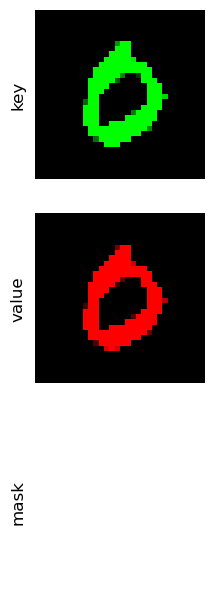

Seed: 0
Editing layer 1
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 44.83it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Found precomputed cov matrices, returning...
n_edit: 1
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([10, 14, 14])
vstar type: <class 'torch.Tensor'> shape: torch.Size([1, 20, 5, 5])
mstar type: <class 'torch.Tensor'> shape: torch.Size([1, 1, 32, 32])
key shape: torch.Size([1, 10, 14, 14]) val shape: torch.Size([1, 20, 5, 5])


tensor(0.8061, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:42<00:00, 940.4


Loss (orig, final): 3.3491387367248535 0.806052029132843
L2 norm of weight change: 125.19380187988281
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 44.68it/s]

Post-edit metrics: {'TP': array([316, 610, 869, 543, 541, 336,   7,  90,   7,   2]), 'TN': array([8394, 8321, 5574, 7534, 7836, 7538, 8584, 8447, 8562, 8531]), 'FPs': array([ 176,   94, 2944, 1006,  732, 1120,    8,   75,   14,   10]), 'FNs': array([614, 475, 113, 417, 391, 506, 901, 888, 917, 957]), 'accuracy': 0.34957894736842104, 'per_class_accuracy': array([0.91684211, 0.94010526, 0.67821053, 0.85021053, 0.88178947,
       0.82884211, 0.90431579, 0.89863158, 0.902     , 0.89821053]), 'per_class_accuracy_mean': 0.8699157894736842, 'precision': array([0.64227642, 0.86647727, 0.22790454, 0.35054874, 0.42498036,
       0.23076923, 0.46666667, 0.54545455, 0.33333333, 0.16666667]), 'precision_mean': 0.4255077777966275, 'recall': array([0.33978495, 0.56221198, 0.88492872, 0.565625  , 0.5804721 ,
       0.39904988, 0.00770925, 0.09202454, 0.00757576, 0.00208551]), 'recall_mean': 0.3441467683236624, 'predicted_class_distribution': array([ 492,  704, 3813, 1549, 1273, 1456,   15,  165,   21,

saved/edit_2_Spurious_MNIST/method_eac/LeNet/0327_101945/results/edit_idx_1
torch.Size([2, 1, 32, 32])
3 2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


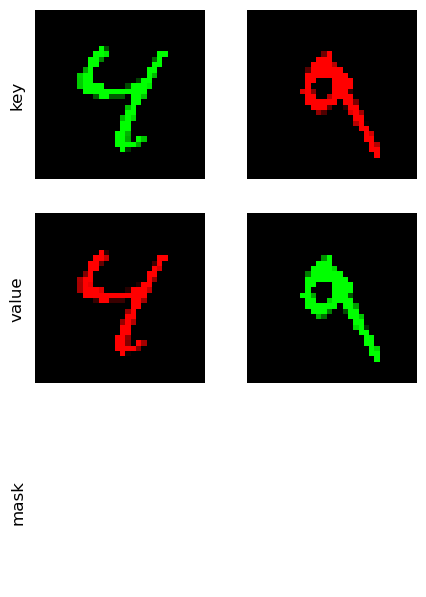

Seed: 0
Editing layer 1
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 45.90it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Found precomputed cov matrices, returning...
n_edit: 2
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([10, 14, 14])
vstar type: <class 'torch.Tensor'> shape: torch.Size([2, 20, 5, 5])
mstar type: <class 'torch.Tensor'> shape: torch.Size([2, 1, 32, 32])
key shape: torch.Size([2, 10, 14, 14]) val shape: torch.Size([2, 20, 5, 5])


tensor(0.4380, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:42<00:00, 933.0

Loss (orig, final): 1.130075216293335 0.437971830368042
L2 norm of weight change: 28.43067741394043
Performing post-edit metric calculations on validation set.



100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 46.13it/s]

Post-edit metrics: {'TP': array([466, 879, 802, 664, 603, 342, 191, 510,  47,  43]), 'TN': array([8299, 8108, 7700, 7489, 7691, 8298, 8413, 7624, 8501, 8424]), 'FPs': array([ 271,  307,  818, 1051,  877,  360,  179,  898,   75,  117]), 'FNs': array([464, 206, 180, 296, 329, 500, 717, 468, 877, 916]), 'accuracy': 0.4786315789473684, 'per_class_accuracy': array([0.92263158, 0.946     , 0.89494737, 0.85821053, 0.87305263,
       0.90947368, 0.90568421, 0.85621053, 0.89978947, 0.89126316]), 'per_class_accuracy_mean': 0.8957263157894738, 'precision': array([0.63229308, 0.74114671, 0.49506173, 0.38717201, 0.40743243,
       0.48717949, 0.51621622, 0.36221591, 0.3852459 , 0.26875   ]), 'precision_mean': 0.4682713478305282, 'recall': array([0.50107527, 0.81013825, 0.81670061, 0.69166667, 0.64699571,
       0.40617577, 0.21035242, 0.52147239, 0.0508658 , 0.04483837]), 'recall_mean': 0.47002812651726167, 'predicted_class_distribution': array([ 737, 1186, 1620, 1715, 1480,  702,  370, 1408,  122,

saved/edit_2_Spurious_MNIST/method_eac/LeNet/0327_101945/results/edit_idx_2
torch.Size([2, 1, 32, 32])
3 2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


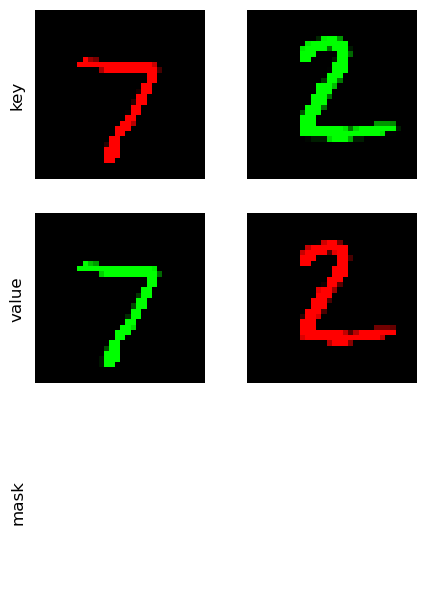

Seed: 0
Editing layer 1
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 46.87it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Found precomputed cov matrices, returning...
n_edit: 2
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([10, 14, 14])
vstar type: <class 'torch.Tensor'> shape: torch.Size([2, 20, 5, 5])
mstar type: <class 'torch.Tensor'> shape: torch.Size([2, 1, 32, 32])
key shape: torch.Size([2, 10, 14, 14]) val shape: torch.Size([2, 20, 5, 5])


tensor(0.5878, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:43<00:00, 923.1

Loss (orig, final): 1.2499332427978516 0.5878270268440247
L2 norm of weight change: 37.56874084472656
Performing post-edit metric calculations on validation set.



100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 44.91it/s]

Post-edit metrics: {'TP': array([524, 655, 548, 544, 573, 337, 215, 325, 229, 229]), 'TN': array([7975, 8249, 7722, 7503, 7651, 8139, 8526, 8276, 7911, 8227]), 'FPs': array([ 595,  166,  796, 1037,  917,  519,   66,  246,  665,  314]), 'FNs': array([406, 430, 434, 416, 359, 505, 693, 653, 695, 730]), 'accuracy': 0.4398947368421053, 'per_class_accuracy': array([0.89463158, 0.93726316, 0.87052632, 0.84705263, 0.86568421,
       0.89221053, 0.92010526, 0.90536842, 0.85684211, 0.89010526]), 'per_class_accuracy_mean': 0.8879789473684211, 'precision': array([0.46827525, 0.79780755, 0.4077381 , 0.34408602, 0.38456376,
       0.39369159, 0.76512456, 0.56917688, 0.25615213, 0.42173112]), 'precision_mean': 0.48083469479294216, 'recall': array([0.56344086, 0.60368664, 0.55804481, 0.56666667, 0.61480687,
       0.40023753, 0.23678414, 0.33231084, 0.2478355 , 0.23879041]), 'recall_mean': 0.436260424991182, 'predicted_class_distribution': array([1119,  821, 1344, 1581, 1490,  856,  281,  571,  894, 

saved/edit_2_Spurious_MNIST/method_eac/LeNet/0327_101945/results/edit_idx_3
torch.Size([2, 1, 32, 32])
3 2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


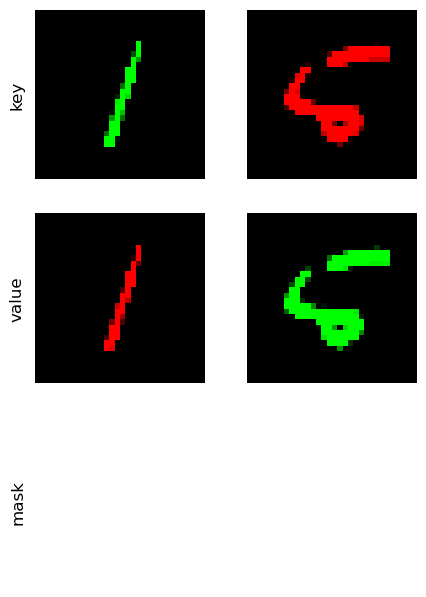

Seed: 0
Editing layer 1
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 45.71it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Found precomputed cov matrices, returning...
n_edit: 2
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([10, 14, 14])
vstar type: <class 'torch.Tensor'> shape: torch.Size([2, 20, 5, 5])
mstar type: <class 'torch.Tensor'> shape: torch.Size([2, 1, 32, 32])
key shape: torch.Size([2, 10, 14, 14]) val shape: torch.Size([2, 20, 5, 5])


tensor(0.7087, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:42<00:00, 934.9

Loss (orig, final): 1.142342209815979 0.7087116837501526
L2 norm of weight change: 72.26177978515625
Performing post-edit metric calculations on validation set.



100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 44.73it/s]


Post-edit metrics: {'TP': array([278, 942, 281,   0, 406, 386, 365, 601, 275, 319]), 'TN': array([8051, 7170, 7870, 8537, 7135, 8393, 8422, 7700, 8356, 8219]), 'FPs': array([ 519, 1245,  648,    3, 1433,  265,  170,  822,  220,  322]), 'FNs': array([652, 143, 701, 960, 526, 456, 543, 377, 649, 640]), 'accuracy': 0.40557894736842104, 'per_class_accuracy': array([0.87673684, 0.85389474, 0.858     , 0.89863158, 0.79378947,
       0.92410526, 0.92494737, 0.87378947, 0.90852632, 0.89873684]), 'per_class_accuracy_mean': 0.8811157894736843, 'precision': array([0.34880803, 0.43072702, 0.30247578, 0.        , 0.22077216,
       0.59293395, 0.68224299, 0.42234715, 0.55555556, 0.49765991]), 'precision_mean': 0.40535225469024133, 'recall': array([0.29892473, 0.86820276, 0.28615071, 0.        , 0.43562232,
       0.4584323 , 0.40198238, 0.61451943, 0.29761905, 0.33263816]), 'recall_mean': 0.3994091849256772, 'predicted_class_distribution': array([ 797, 2187,  929,    3, 1839,  651,  535, 1423,  495

/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


saved/edit_2_Spurious_MNIST/method_eac/LeNet/0327_101945/results/edit_idx_4
torch.Size([2, 1, 32, 32])
3 2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


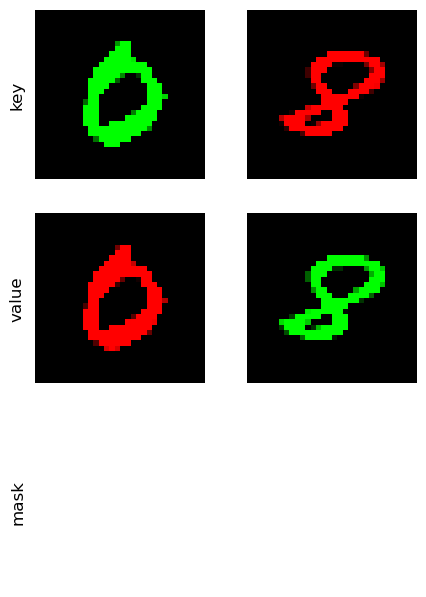

Seed: 0
Editing layer 1
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 45.25it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Saved pre-edit metrics saved/edit_2_Spurious_MNIST/method_eac/LeNet/0327_101945/results/edit_idx_4/models/pre_edit_metrics.pth
Saved pre-edit logits to saved/edit_2_Spurious_MNIST/method_eac/LeNet/0327_101945/results/edit_idx_4/models/pre_edit_logits.pth
Created <class 'trainer.editor.EditorEAC'> editor.
Is covariance_dataset in config? True
Created dataloader for covariance matrix from 2_Spurious_MNIST_hold_out
Looking for covariance matrix weights in cache/2_Spurious_MNIST_hold_out/lenet-1
Found precomputed cov matrices, returning...
n_edit: 2
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([10, 14, 14])
vstar type: <class 'torch.Tensor'> shape: torch.Size([2, 20, 5, 5])
mstar type: <class 'torch.Tensor'> shape: torch.Size([2, 1, 32, 32])
key shape: torch.Size([2, 10, 14, 14]) val shape: torch.Size([2, 20, 5, 5])


tensor(0.6256, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:42<00:00, 932.1

Loss (orig, final): 1.5306638479232788 0.6255865693092346
L2 norm of weight change: 41.066856384277344
Performing post-edit metric calculations on validation set.



100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 44.10it/s]

Post-edit metrics: {'TP': array([804, 978, 814, 626, 782,  75,   0,  73,   0,   3]), 'TN': array([8067, 8132, 7304, 7788, 6089, 8577, 8592, 8503, 8568, 8535]), 'FPs': array([ 503,  283, 1214,  752, 2479,   81,    0,   19,    8,    6]), 'FNs': array([126, 107, 168, 334, 150, 767, 908, 905, 924, 956]), 'accuracy': 0.4373684210526316, 'per_class_accuracy': array([0.93378947, 0.95894737, 0.85452632, 0.88568421, 0.72326316,
       0.91073684, 0.90442105, 0.90273684, 0.90189474, 0.89873684]), 'per_class_accuracy_mean': 0.8874736842105262, 'precision': array([0.6151492 , 0.77557494, 0.40138067, 0.45428157, 0.23980374,
       0.48076923, 0.        , 0.79347826, 0.        , 0.33333333]), 'precision_mean': 0.40937709414132756, 'recall': array([0.86451613, 0.90138249, 0.82892057, 0.65208333, 0.83905579,
       0.08907363, 0.        , 0.07464213, 0.        , 0.00312826]), 'recall_mean': 0.42528023346973887, 'predicted_class_distribution': array([1307, 1261, 2028, 1378, 3261,  156,    0,   92,    8


/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


saved/edit_2_Spurious_MNIST/method_eac/LeNet/0327_101945/results/edit_idx_5
torch.Size([2, 1, 32, 32])
3 2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


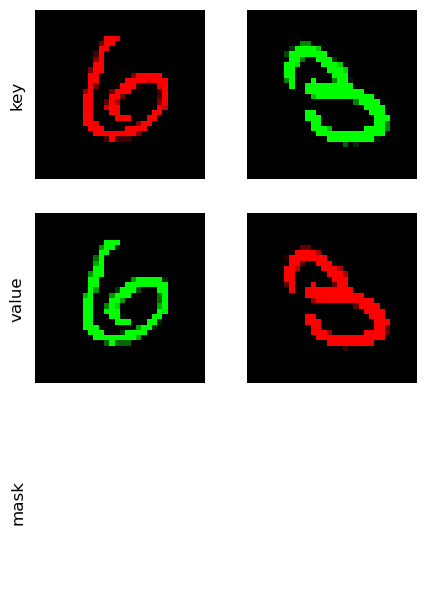

Seed: 0
Editing layer 1
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 44.73it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Found precomputed cov matrices, returning...
n_edit: 2
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([10, 14, 14])
vstar type: <class 'torch.Tensor'> shape: torch.Size([2, 20, 5, 5])
mstar type: <class 'torch.Tensor'> shape: torch.Size([2, 1, 32, 32])
key shape: torch.Size([2, 10, 14, 14]) val shape: torch.Size([2, 20, 5, 5])


tensor(0.5402, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:42<00:00, 932.7

Loss (orig, final): 1.3505364656448364 0.540203869342804
L2 norm of weight change: 28.51508331298828
Performing post-edit metric calculations on validation set.



100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 45.98it/s]

Post-edit metrics: {'TP': array([570, 441, 753, 561, 438, 125, 263, 307, 242, 335]), 'TN': array([7943, 8383, 6716, 6996, 8218, 8604, 8547, 8292, 8214, 8122]), 'FPs': array([ 627,   32, 1802, 1544,  350,   54,   45,  230,  362,  419]), 'FNs': array([360, 644, 229, 399, 494, 717, 645, 671, 682, 624]), 'accuracy': 0.42473684210526313, 'per_class_accuracy': array([0.89610526, 0.92884211, 0.78621053, 0.79547368, 0.91115789,
       0.91884211, 0.92736842, 0.90515789, 0.89010526, 0.89021053]), 'per_class_accuracy_mean': 0.8849473684210526, 'precision': array([0.47619048, 0.93234672, 0.29471624, 0.26650831, 0.55583756,
       0.69832402, 0.8538961 , 0.5716946 , 0.40066225, 0.44429708]), 'precision_mean': 0.5494473378641069, 'recall': array([0.61290323, 0.40645161, 0.76680244, 0.584375  , 0.46995708,
       0.14845606, 0.28964758, 0.31390593, 0.26190476, 0.34932221]), 'recall_mean': 0.420372590135742, 'predicted_class_distribution': array([1197,  473, 2555, 2105,  788,  179,  308,  537,  604, 

saved/edit_2_Spurious_MNIST/method_eac/LeNet/0327_101945/results/edit_idx_6
torch.Size([3, 1, 32, 32])
3 3
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


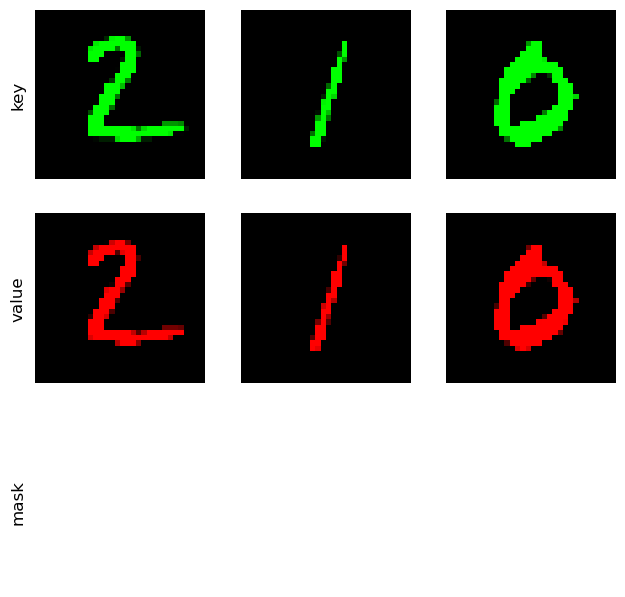

Seed: 0
Editing layer 1
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 44.85it/s]


Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

tensor(0.2308, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:42<00:00, 948.6

Loss (orig, final): 0.8320460319519043 0.23083452880382538
L2 norm of weight change: 16.384912490844727
Performing post-edit metric calculations on validation set.



100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 45.02it/s]

Post-edit metrics: {'TP': array([ 903, 1081,  862,  663,  875,  339,   20,  180,    3,   11]), 'TN': array([8123, 8066, 8018, 7758, 6737, 8142, 8592, 8405, 8576, 8520]), 'FPs': array([ 447,  349,  500,  782, 1831,  516,    0,  117,    0,   21]), 'FNs': array([ 27,   4, 120, 297,  57, 503, 888, 798, 921, 948]), 'accuracy': 0.5196842105263157, 'per_class_accuracy': array([0.95010526, 0.96284211, 0.93473684, 0.88642105, 0.80126316,
       0.89273684, 0.90652632, 0.90368421, 0.90305263, 0.898     ]), 'per_class_accuracy_mean': 0.9039368421052633, 'precision': array([0.66888889, 0.75594406, 0.6328928 , 0.45882353, 0.32335551,
       0.39649123, 1.        , 0.60606061, 1.        , 0.34375   ]), 'precision_mean': 0.6186206619356799, 'recall': array([0.97096774, 0.99631336, 0.87780041, 0.690625  , 0.9388412 ,
       0.40261283, 0.02202643, 0.18404908, 0.00324675, 0.01147028]), 'recall_mean': 0.5097953087905512, 'predicted_class_distribution': array([1350, 1430, 1362, 1445, 2706,  855,   20,  2

saved/edit_2_Spurious_MNIST/method_eac/LeNet/0327_101945/results/edit_idx_7
torch.Size([2, 1, 32, 32])
3 2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


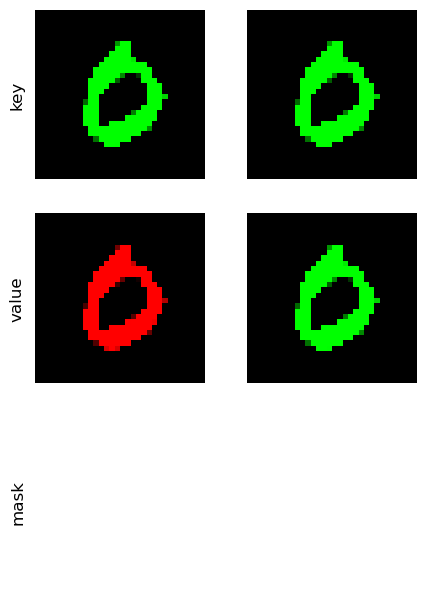

Seed: 0
Editing layer 1
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 43.97it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Found precomputed cov matrices, returning...
n_edit: 2
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([10, 14, 14])
vstar type: <class 'torch.Tensor'> shape: torch.Size([2, 20, 5, 5])
mstar type: <class 'torch.Tensor'> shape: torch.Size([2, 1, 32, 32])
key shape: torch.Size([2, 10, 14, 14]) val shape: torch.Size([2, 20, 5, 5])


tensor(0.8822, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:43<00:00, 919.1

Loss (orig, final): 0.8372846841812134 0.8822131752967834
L2 norm of weight change: 35.557559967041016
Performing post-edit metric calculations on validation set.



100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 44.09it/s]

Post-edit metrics: {'TP': array([699, 962, 733, 783, 617, 268, 203, 296, 130, 188]), 'TN': array([8242, 8298, 7852, 6984, 7483, 8402, 8549, 8365, 8394, 8310]), 'FPs': array([ 328,  117,  666, 1556, 1085,  256,   43,  157,  182,  231]), 'FNs': array([231, 123, 249, 177, 315, 574, 705, 682, 794, 771]), 'accuracy': 0.513578947368421, 'per_class_accuracy': array([0.94115789, 0.97473684, 0.90368421, 0.81757895, 0.85263158,
       0.91263158, 0.92126316, 0.91168421, 0.89726316, 0.89452632]), 'per_class_accuracy_mean': 0.9027157894736841, 'precision': array([0.68062317, 0.89156627, 0.52394568, 0.33475844, 0.36251469,
       0.51145038, 0.82520325, 0.65342163, 0.41666667, 0.44868735]), 'precision_mean': 0.5648837531985809, 'recall': array([0.7516129 , 0.88663594, 0.74643585, 0.815625  , 0.66201717,
       0.31828979, 0.22356828, 0.30265849, 0.14069264, 0.19603754]), 'recall_mean': 0.5043573595187135, 'predicted_class_distribution': array([1027, 1079, 1399, 2339, 1702,  524,  246,  453,  312,  

saved/edit_2_Spurious_MNIST/method_eac/LeNet/0327_101945/results/edit_idx_8
torch.Size([4, 1, 32, 32])
3 4
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


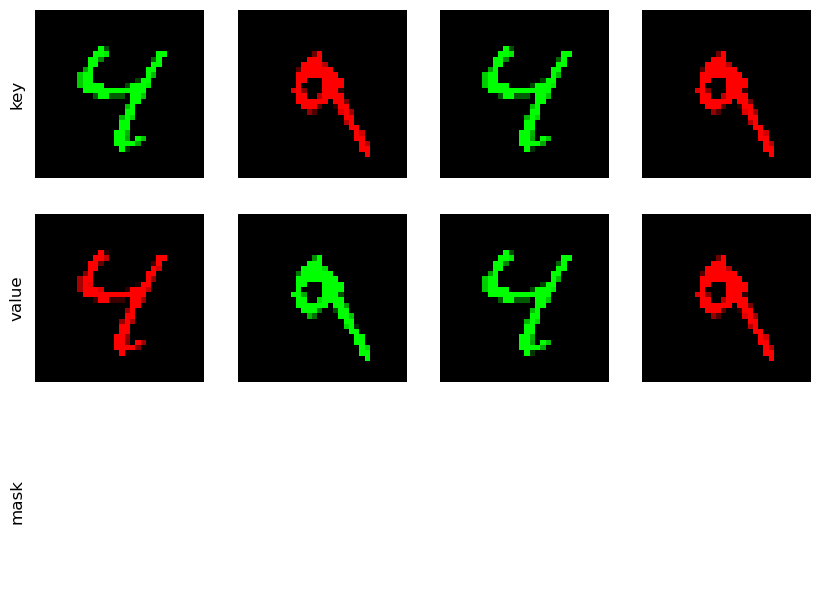

Seed: 0
Editing layer 1
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 45.31it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Found precomputed cov matrices, returning...
n_edit: 4
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([10, 14, 14])
vstar type: <class 'torch.Tensor'> shape: torch.Size([4, 20, 5, 5])
mstar type: <class 'torch.Tensor'> shape: torch.Size([4, 1, 32, 32])
key shape: torch.Size([4, 10, 14, 14]) val shape: torch.Size([4, 20, 5, 5])


tensor(0.3079, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:43<00:00, 912.9

Loss (orig, final): 0.28251880407333374 0.3079023063182831
L2 norm of weight change: 12.416589736938477
Performing post-edit metric calculations on validation set.



100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 44.57it/s]

Post-edit metrics: {'TP': array([450, 540, 519, 499, 451, 423, 440, 480, 440, 432]), 'TN': array([8288, 8277, 8213, 7705, 7765, 8276, 8229, 8008, 7886, 8027]), 'FPs': array([282, 138, 305, 835, 803, 382, 363, 514, 690, 514]), 'FNs': array([480, 545, 463, 461, 481, 419, 468, 498, 484, 527]), 'accuracy': 0.492, 'per_class_accuracy': array([0.91978947, 0.92810526, 0.91915789, 0.86357895, 0.86484211,
       0.91568421, 0.91252632, 0.89347368, 0.87642105, 0.89042105]), 'per_class_accuracy_mean': 0.8984, 'precision': array([0.6147541 , 0.79646018, 0.62985437, 0.37406297, 0.35964912,
       0.52546584, 0.54794521, 0.48289738, 0.38938053, 0.45665962]), 'precision_mean': 0.5177129314324976, 'recall': array([0.48387097, 0.49769585, 0.52851324, 0.51979167, 0.48390558,
       0.5023753 , 0.4845815 , 0.49079755, 0.47619048, 0.45046924]), 'recall_mean': 0.4918191360334136, 'predicted_class_distribution': array([ 732,  678,  824, 1334, 1254,  805,  803,  994, 1130,  946]), 'f1': array([0.54151625, 0.

(0327_102639) Starting Trial 10/14...
saved/edit_2_Spurious_MNIST/method_eac/LeNet/0327_101945/results/edit_idx_9
torch.Size([4, 1, 32, 32])
3 4
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or

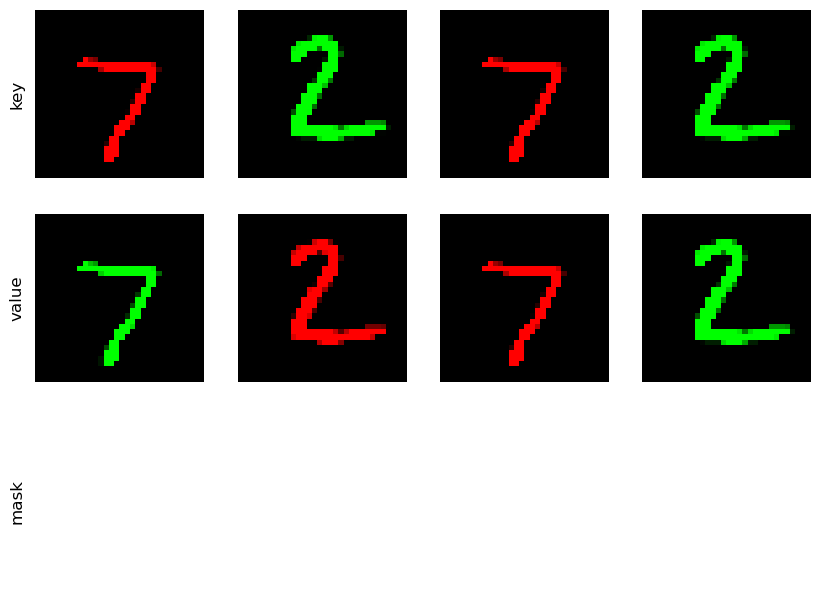

Seed: 0
Editing layer 1
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 45.46it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Found precomputed cov matrices, returning...
n_edit: 4
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([10, 14, 14])
vstar type: <class 'torch.Tensor'> shape: torch.Size([4, 20, 5, 5])
mstar type: <class 'torch.Tensor'> shape: torch.Size([4, 1, 32, 32])
key shape: torch.Size([4, 10, 14, 14]) val shape: torch.Size([4, 20, 5, 5])


tensor(0.3426, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:43<00:00, 920.9


Loss (orig, final): 0.3124833106994629 0.34260880947113037
L2 norm of weight change: 15.773180961608887
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 45.28it/s]

Post-edit metrics: {'TP': array([451, 537, 522, 503, 453, 422, 434, 472, 450, 440]), 'TN': array([8247, 8334, 8187, 7643, 7834, 8234, 8429, 8085, 7643, 8048]), 'FPs': array([323,  81, 331, 897, 734, 424, 163, 437, 933, 493]), 'FNs': array([479, 548, 460, 457, 479, 420, 474, 506, 474, 519]), 'accuracy': 0.49305263157894735, 'per_class_accuracy': array([0.91557895, 0.93378947, 0.91673684, 0.85747368, 0.87231579,
       0.91115789, 0.93294737, 0.90073684, 0.85189474, 0.89347368]), 'per_class_accuracy_mean': 0.8986105263157895, 'precision': array([0.58268734, 0.86893204, 0.6119578 , 0.35928571, 0.38163437,
       0.49881797, 0.72696817, 0.51925193, 0.32537961, 0.471597  ]), 'precision_mean': 0.5346511934775943, 'recall': array([0.48494624, 0.49493088, 0.53156823, 0.52395833, 0.4860515 ,
       0.50118765, 0.47797357, 0.48261759, 0.48701299, 0.45881126]), 'recall_mean': 0.4929058228114357, 'predicted_class_distribution': array([ 774,  618,  853, 1400, 1187,  846,  597,  909, 1383,  933]), '

saved/edit_2_Spurious_MNIST/method_eac/LeNet/0327_101945/results/edit_idx_10
torch.Size([4, 1, 32, 32])
3 4
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


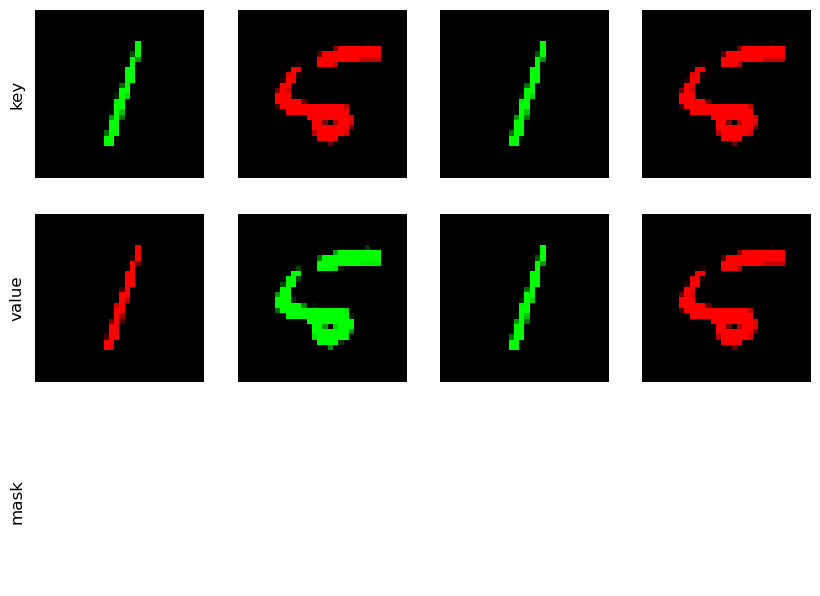

Seed: 0
Editing layer 1
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 44.06it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Found precomputed cov matrices, returning...
n_edit: 4
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([10, 14, 14])
vstar type: <class 'torch.Tensor'> shape: torch.Size([4, 20, 5, 5])
mstar type: <class 'torch.Tensor'> shape: torch.Size([4, 1, 32, 32])
key shape: torch.Size([4, 10, 14, 14]) val shape: torch.Size([4, 20, 5, 5])


tensor(0.3641, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:43<00:00, 917.4


Loss (orig, final): 0.28558555245399475 0.36410579085350037
L2 norm of weight change: 43.940650939941406
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 43.50it/s]

Post-edit metrics: {'TP': array([394, 752, 322, 141, 471, 444, 389, 520, 388, 433]), 'TN': array([8366, 8209, 8272, 8374, 6091, 7924, 8528, 8168, 8211, 8111]), 'FPs': array([ 204,  206,  246,  166, 2477,  734,   64,  354,  365,  430]), 'FNs': array([536, 333, 660, 819, 461, 398, 519, 458, 536, 526]), 'accuracy': 0.4477894736842105, 'per_class_accuracy': array([0.92210526, 0.94326316, 0.90463158, 0.89631579, 0.69073684,
       0.88084211, 0.93863158, 0.91452632, 0.90515789, 0.89936842]), 'per_class_accuracy_mean': 0.8895578947368421, 'precision': array([0.65886288, 0.78496868, 0.56690141, 0.45928339, 0.15976934,
       0.37691002, 0.85871965, 0.59496568, 0.51527224, 0.50173812]), 'precision_mean': 0.5477391398246929, 'recall': array([0.42365591, 0.69308756, 0.32790224, 0.146875  , 0.50536481,
       0.52731591, 0.4284141 , 0.53169734, 0.41991342, 0.45151199]), 'recall_mean': 0.4455738283265299, 'predicted_class_distribution': array([ 598,  958,  568,  307, 2948, 1178,  453,  874,  753, 

saved/edit_2_Spurious_MNIST/method_eac/LeNet/0327_101945/results/edit_idx_11
torch.Size([4, 1, 32, 32])
3 4
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


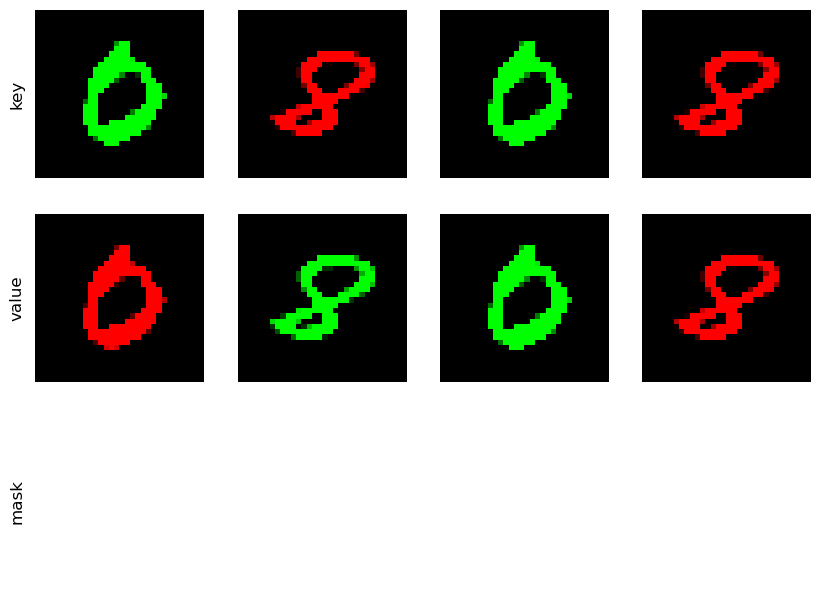

Seed: 0
Editing layer 1
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 45.24it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Saved pre-edit logits to saved/edit_2_Spurious_MNIST/method_eac/LeNet/0327_101945/results/edit_idx_11/models/pre_edit_logits.pth
Created <class 'trainer.editor.EditorEAC'> editor.
Is covariance_dataset in config? True
Created dataloader for covariance matrix from 2_Spurious_MNIST_hold_out
Looking for covariance matrix weights in cache/2_Spurious_MNIST_hold_out/lenet-1
Found precomputed cov matrices, returning...
n_edit: 4
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([10, 14, 14])
vstar type: <class 'torch.Tensor'> shape: torch.Size([4, 20, 5, 5])
mstar type: <class 'torch.Tensor'> shape: torch.Size([4, 1, 32, 32])
key shape: torch.Size([4, 10, 14, 14]) val shape: torch.Size([4, 20, 5, 5])


tensor(0.4093, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:43<00:00, 916.3


Loss (orig, final): 0.3826659619808197 0.40932855010032654
L2 norm of weight change: 18.336076736450195
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 44.01it/s]

Post-edit metrics: {'TP': array([456, 685, 565, 495, 461, 424, 424, 472, 393, 424]), 'TN': array([8305, 8291, 8164, 7737, 7657, 8010, 8385, 8147, 8171, 7932]), 'FPs': array([265, 124, 354, 803, 911, 648, 207, 375, 405, 609]), 'FNs': array([474, 400, 417, 465, 471, 418, 484, 506, 531, 535]), 'accuracy': 0.5051578947368421, 'per_class_accuracy': array([0.92221053, 0.94484211, 0.91884211, 0.86652632, 0.85452632,
       0.88778947, 0.92726316, 0.90726316, 0.90147368, 0.87957895]), 'per_class_accuracy_mean': 0.9010315789473683, 'precision': array([0.63245492, 0.84672435, 0.61479869, 0.38135593, 0.33600583,
       0.39552239, 0.67194929, 0.55726092, 0.4924812 , 0.41045499]), 'precision_mean': 0.5339008516397749, 'recall': array([0.49032258, 0.63133641, 0.57535642, 0.515625  , 0.49463519,
       0.50356295, 0.46696035, 0.48261759, 0.42532468, 0.44212722]), 'recall_mean': 0.502786837066444, 'predicted_class_distribution': array([ 721,  809,  919, 1298, 1372, 1072,  631,  847,  798, 1033]), 'f1

saved/edit_2_Spurious_MNIST/method_eac/LeNet/0327_101945/results/edit_idx_12
torch.Size([4, 1, 32, 32])
3 4
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


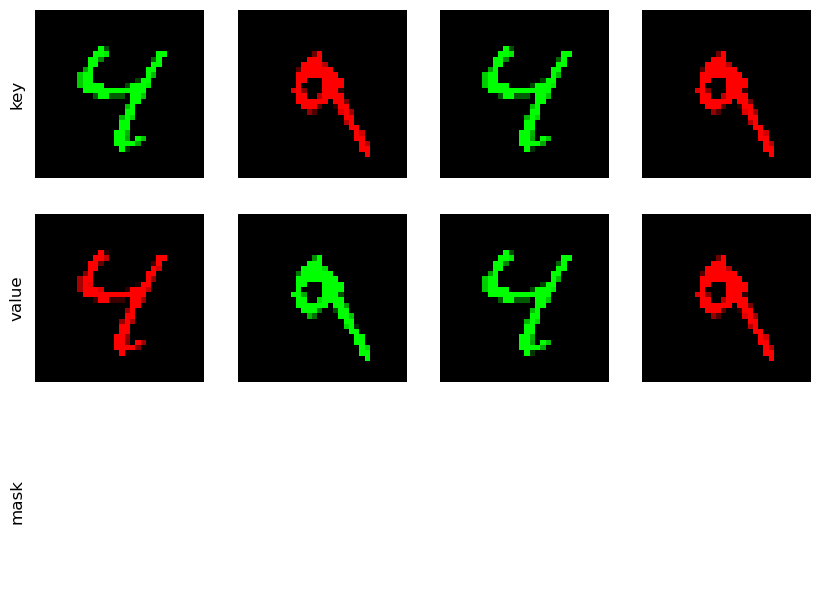

Seed: 0
Editing layer 1
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 44.27it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Found precomputed cov matrices, returning...
n_edit: 4
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([10, 14, 14])
vstar type: <class 'torch.Tensor'> shape: torch.Size([4, 20, 5, 5])
mstar type: <class 'torch.Tensor'> shape: torch.Size([4, 1, 32, 32])
key shape: torch.Size([4, 10, 14, 14]) val shape: torch.Size([4, 20, 5, 5])


tensor(0.3079, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:42<00:00, 944.3


Loss (orig, final): 0.28251880407333374 0.3079023063182831
L2 norm of weight change: 12.416589736938477
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 43.74it/s]

Post-edit metrics: {'TP': array([450, 540, 519, 499, 451, 423, 440, 480, 440, 432]), 'TN': array([8288, 8277, 8213, 7705, 7765, 8276, 8229, 8008, 7886, 8027]), 'FPs': array([282, 138, 305, 835, 803, 382, 363, 514, 690, 514]), 'FNs': array([480, 545, 463, 461, 481, 419, 468, 498, 484, 527]), 'accuracy': 0.492, 'per_class_accuracy': array([0.91978947, 0.92810526, 0.91915789, 0.86357895, 0.86484211,
       0.91568421, 0.91252632, 0.89347368, 0.87642105, 0.89042105]), 'per_class_accuracy_mean': 0.8984, 'precision': array([0.6147541 , 0.79646018, 0.62985437, 0.37406297, 0.35964912,
       0.52546584, 0.54794521, 0.48289738, 0.38938053, 0.45665962]), 'precision_mean': 0.5177129314324976, 'recall': array([0.48387097, 0.49769585, 0.52851324, 0.51979167, 0.48390558,
       0.5023753 , 0.4845815 , 0.49079755, 0.47619048, 0.45046924]), 'recall_mean': 0.4918191360334136, 'predicted_class_distribution': array([ 732,  678,  824, 1334, 1254,  805,  803,  994, 1130,  946]), 'f1': array([0.54151625, 0.

Saved post-edit logits to saved/edit_2_Spurious_MNIST/method_eac/LeNet/0327_101945/results/edit_idx_12/models/post_edit_logits.pth
All metrics and KNN results can be found in saved/edit_2_Spurious_MNIST/method_eac/LeNet/0327_101945/results/edit_idx_12/models
(0327_102941) Starting Trial 14/14...
saved/edit_2_Spurious_MNIST/method_eac/LeNet/0327_101945/results/edit_idx_13
torch.Size([6, 1, 32, 32])
3 6
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for im

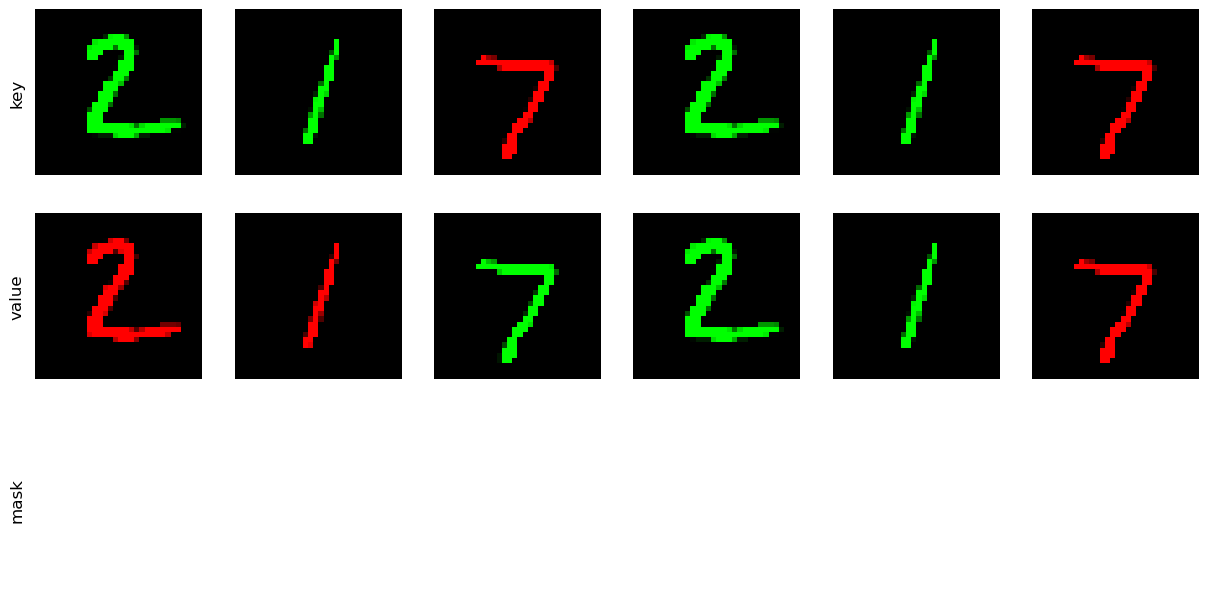

Seed: 0
Editing layer 1
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 44.25it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Found precomputed cov matrices, returning...
n_edit: 6
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([10, 14, 14])
vstar type: <class 'torch.Tensor'> shape: torch.Size([6, 20, 5, 5])
mstar type: <class 'torch.Tensor'> shape: torch.Size([6, 1, 32, 32])
key shape: torch.Size([6, 10, 14, 14]) val shape: torch.Size([6, 20, 5, 5])


tensor(0.1898, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:43<00:00, 918.7

Loss (orig, final): 0.1784382313489914 0.18979154527187347
L2 norm of weight change: 13.483278274536133
Performing post-edit metric calculations on validation set.



100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 43.98it/s]

Post-edit metrics: {'TP': array([450, 567, 522, 501, 453, 423, 434, 471, 443, 442]), 'TN': array([8257, 8339, 8232, 7601, 7815, 8163, 8364, 8109, 7819, 8007]), 'FPs': array([313,  76, 286, 939, 753, 495, 228, 413, 757, 534]), 'FNs': array([480, 518, 460, 459, 479, 419, 474, 507, 481, 517]), 'accuracy': 0.49536842105263157, 'per_class_accuracy': array([0.91652632, 0.93747368, 0.92147368, 0.85284211, 0.87031579,
       0.90378947, 0.92610526, 0.90315789, 0.86968421, 0.88936842]), 'per_class_accuracy_mean': 0.8990736842105264, 'precision': array([0.5897772 , 0.88180404, 0.6460396 , 0.34791667, 0.37562189,
       0.46078431, 0.65558912, 0.53280543, 0.36916667, 0.45286885]), 'precision_mean': 0.5312373786584483, 'recall': array([0.48387097, 0.52258065, 0.53156823, 0.521875  , 0.4860515 ,
       0.5023753 , 0.47797357, 0.48159509, 0.47943723, 0.46089677]), 'recall_mean': 0.4948224297276987, 'predicted_class_distribution': array([ 763,  643,  808, 1440, 1206,  918,  662,  884, 1200,  976]), '

In [84]:
run_trials(
    edit_data_loader=edit_data_loader,
    progress_report_path=progress_report_path,
    trial_paths_path=trial_paths_path,
    test_data_loader=test_data_loader,
    # covariance_data_loader=covariance_data_loader,
    config_dict=config_dict,
    run_id_prefix=os.path.join(timestamp),
    debug=True,
    seed=0)


### Run experiments varying some variable

In [53]:
def get_nested_dict_value(keys: list,
                          dictionary: dict):
    
    # Base case
    if len(keys) == 1:
        try:
            return dictionary[keys[0]]
        except:
            print("in except")
            return None
    else:
        try:
            item = dictionary[keys[0]]
            return get_nested_dict_value(
                keys=keys[1:],
                dictionary=item)
        except:
            print("in except")
            return None
        
def set_nested_dict_value(keys: list,
                          dictionary: dict,
                          value: any):
    '''
    DOES change the original dictionary
    '''
    
    # Base case
    if len(keys) == 1:
        dictionary[keys[0]] = value
        return True
    else:
        try:
            item = dictionary[keys[0]]
            if not isinstance(item, dict):
                return False
            else:
                return set_nested_dict_value(
                    keys=keys[1:],
                    dictionary=item,
                    value=value)
        except:
            print("in except")
            return False

def run_experiments(iv_path: str,
                    iv_values: list,
                    edit_data_loader: list,
                    progress_report_path: str,
                    trial_paths_path: str,
                    timestamp: str,
                    config_dict: dict,
                    test_data_loader=None,
                    covariance_data_loader=None,
                    analyze_in_edit=True,
                    debug=True,
                    seed: int=0):
    
    iv_path_list = iv_path.split('/')
    
    if get_nested_dict_value(keys=iv_path_list, dictionary=config_dict) is None:
        raise ValueError("Could not find path of keys {} in config dictionary".format(iv_path))

    n_experiments = len(iv_values)
    for iv_idx, iv_value in enumerate(iv_values):
        # config_dict[iv_name] = iv_value
        if not set_nested_dict_value(
            keys=iv_path_list,
            dictionary=config_dict,
            value=iv_value):
            raise ValueError("Unable to set value of {} to {}".format(iv_path, iv_value))
        informal_log("Experimenting with {} of {}".format(iv_path, iv_value), progress_report_path)
        
        run_id_prefix = os.path.join(timestamp, '{}_{}'.format(iv_path.replace('/', '_'), iv_value))
        
        run_trials(
            edit_data_loader=edit_data_loader,
            test_data_loader=test_data_loader,
            covariance_data_loader=covariance_data_loader,
            config_dict=config_dict,
            run_id_prefix=run_id_prefix,
            progress_report_path=progress_report_path,
            trial_paths_path=trial_paths_path,
            debug=debug,
            analyze_in_edit=analyze_in_edit,
            seed=seed)
            

#### Run experiments varying layer number

Varying layernum with following values: [0, 1]
Experimenting with layernum of 0
(0324_170239) Starting Trial 1/16...
saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_0/results/edit_idx_0
torch.Size([2, 1, 32, 32])
3 2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


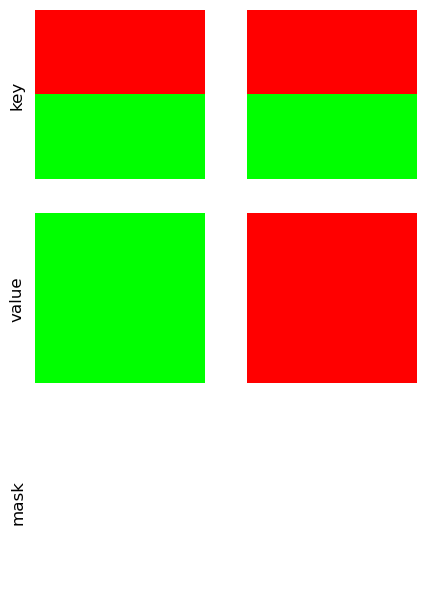

Seed: 0
Editing layer 0
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 39.87it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1


100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.87it/s]


acts shape: torch.Size([256, 3, 32, 32])
acts shape: torch.Size([244, 3, 32, 32])
Cov shape: torch.Size([3, 3])
n_edit: 2
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([3, 32, 32])
vstar type: <class 'torch.Tensor'> shape: torch.Size([2, 10, 14, 14])
mstar type: <class 'torch.Tensor'> shape: torch.Size([2, 1, 32, 32])
key shape: torch.Size([2, 3, 32, 32]) val shape: torch.Size([2, 10, 14, 14])


tensor(0.5822, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 30000/30000 [00:41<00:00, 715.1

Loss (orig, final): 0.6493484973907471 0.5822376012802124
L2 norm of weight change: 2.2028045654296875
Performing post-edit metric calculations on validation set.



100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 40.10it/s]

Post-edit metrics: {'TP': array([456, 539, 546, 539, 454, 186, 439, 350, 445, 300]), 'TN': array([8249, 8304, 8225, 7680, 7793, 8538, 7869, 8114, 7143, 8339]), 'FPs': array([ 321,  111,  293,  860,  775,  120,  723,  408, 1433,  202]), 'FNs': array([474, 546, 436, 421, 478, 656, 469, 628, 479, 659]), 'accuracy': 0.4477894736842105, 'per_class_accuracy': array([0.91631579, 0.93084211, 0.92326316, 0.86515789, 0.86810526,
       0.91831579, 0.87452632, 0.89094737, 0.79873684, 0.90936842]), 'per_class_accuracy_mean': 0.8895578947368422, 'precision': array([0.58687259, 0.82923077, 0.65077473, 0.3852752 , 0.36940602,
       0.60784314, 0.3777969 , 0.46174142, 0.23695421, 0.59760956]), 'precision_mean': 0.5103504537957402, 'recall': array([0.49032258, 0.49677419, 0.55600815, 0.56145833, 0.48712446,
       0.22090261, 0.48348018, 0.35787321, 0.48160173, 0.31282586]), 'recall_mean': 0.44483713092305577, 'predicted_class_distribution': array([ 777,  650,  839, 1399, 1229,  306, 1162,  758, 1878,

saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_0/results/edit_idx_1
torch.Size([2, 1, 32, 32])
3 2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


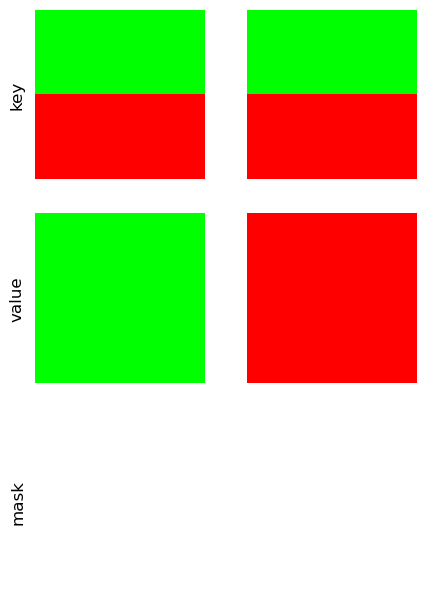

Seed: 0
Editing layer 0
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 40.20it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Found precomputed cov matrices, returning...
n_edit: 2
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([3, 32, 32])
vstar type: <class 'torch.Tensor'> shape: torch.Size([2, 10, 14, 14])
mstar type: <class 'torch.Tensor'> shape: torch.Size([2, 1, 32, 32])
key shape: torch.Size([2, 3, 32, 32]) val shape: torch.Size([2, 10, 14, 14])


tensor(0.5685, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 30000/30000 [00:41<00:00, 725.8


Loss (orig, final): 0.6477403044700623 0.5685129761695862
L2 norm of weight change: 2.5861124992370605
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 39.65it/s]

Post-edit metrics: {'TP': array([599, 539, 727, 643, 455, 191, 318, 360, 399, 185]), 'TN': array([8257, 8309, 8221, 7580, 7792, 8478, 8496, 7687, 7813, 7783]), 'FPs': array([313, 106, 297, 960, 776, 180,  96, 835, 763, 758]), 'FNs': array([331, 546, 255, 317, 477, 651, 590, 618, 525, 774]), 'accuracy': 0.4648421052631579, 'per_class_accuracy': array([0.93221053, 0.93136842, 0.94189474, 0.86557895, 0.86810526,
       0.91252632, 0.92778947, 0.84705263, 0.86442105, 0.83873684]), 'per_class_accuracy_mean': 0.8929684210526314, 'precision': array([0.65679825, 0.83565891, 0.70996094, 0.40112289, 0.3696182 ,
       0.5148248 , 0.76811594, 0.30125523, 0.34337349, 0.1961824 ]), 'precision_mean': 0.5096911049584185, 'recall': array([0.64408602, 0.49677419, 0.74032587, 0.66979167, 0.48819742,
       0.22684086, 0.35022026, 0.36809816, 0.43181818, 0.19290928]), 'recall_mean': 0.4609061913445557, 'predicted_class_distribution': array([ 912,  645, 1024, 1603, 1231,  371,  414, 1195, 1162,  943]), 'f

saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_0/results/edit_idx_2
torch.Size([2, 1, 32, 32])
3 2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


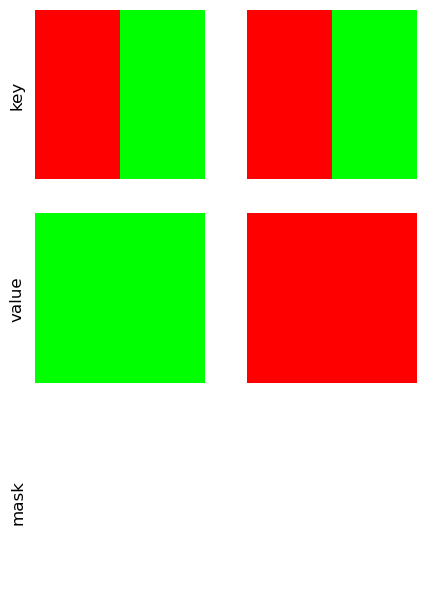

Seed: 0
Editing layer 0
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 22.77it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Found precomputed cov matrices, returning...
n_edit: 2
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([3, 32, 32])
vstar type: <class 'torch.Tensor'> shape: torch.Size([2, 10, 14, 14])
mstar type: <class 'torch.Tensor'> shape: torch.Size([2, 1, 32, 32])
key shape: torch.Size([2, 3, 32, 32]) val shape: torch.Size([2, 10, 14, 14])


tensor(0.5539, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 30000/30000 [00:41<00:00, 729.6

Loss (orig, final): 0.6169161200523376 0.553902268409729
L2 norm of weight change: 1.8420671224594116
Performing post-edit metric calculations on validation set.



100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 38.56it/s]

Post-edit metrics: {'TP': array([450, 720, 518, 498, 452, 410, 424, 365, 450, 271]), 'TN': array([8247, 8290, 8230, 7710, 7776, 8271, 8291, 8488, 6982, 8273]), 'FPs': array([ 323,  125,  288,  830,  792,  387,  301,   34, 1594,  268]), 'FNs': array([480, 365, 464, 462, 480, 432, 484, 613, 474, 688]), 'accuracy': 0.47978947368421054, 'per_class_accuracy': array([0.91547368, 0.94842105, 0.92084211, 0.864     , 0.86610526,
       0.91378947, 0.91736842, 0.93189474, 0.78231579, 0.89936842]), 'per_class_accuracy_mean': 0.8959578947368421, 'precision': array([0.58214748, 0.85207101, 0.6426799 , 0.375     , 0.36334405,
       0.51442911, 0.58482759, 0.91478697, 0.22015656, 0.50278293]), 'precision_mean': 0.5552225585381597, 'recall': array([0.48387097, 0.66359447, 0.52749491, 0.51875   , 0.48497854,
       0.48693587, 0.46696035, 0.37321063, 0.48701299, 0.28258603]), 'recall_mean': 0.4775394754388528, 'predicted_class_distribution': array([ 773,  845,  806, 1328, 1244,  797,  725,  399, 2044,

saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_0/results/edit_idx_3
torch.Size([2, 1, 32, 32])
3 2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


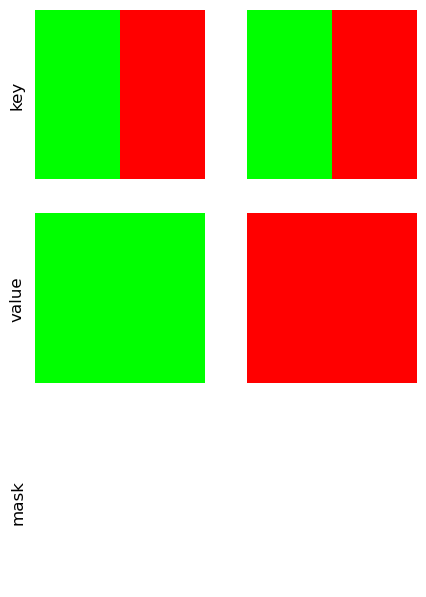

Seed: 0
Editing layer 0
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 38.87it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Found precomputed cov matrices, returning...
n_edit: 2
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([3, 32, 32])
vstar type: <class 'torch.Tensor'> shape: torch.Size([2, 10, 14, 14])
mstar type: <class 'torch.Tensor'> shape: torch.Size([2, 1, 32, 32])
key shape: torch.Size([2, 3, 32, 32]) val shape: torch.Size([2, 10, 14, 14])


tensor(0.5494, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 30000/30000 [00:42<00:00, 708.7

Loss (orig, final): 0.566157341003418 0.5494059324264526
L2 norm of weight change: 1.6414222717285156
Performing post-edit metric calculations on validation set.



100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 40.85it/s]

Post-edit metrics: {'TP': array([450, 572, 518, 496, 452, 418, 429, 436, 453, 415]), 'TN': array([8249, 8290, 8229, 7709, 7777, 8268, 8212, 8455, 7306, 8144]), 'FPs': array([ 321,  125,  289,  831,  791,  390,  380,   67, 1270,  397]), 'FNs': array([480, 513, 464, 464, 480, 424, 479, 542, 471, 544]), 'accuracy': 0.4883157894736842, 'per_class_accuracy': array([0.91568421, 0.93284211, 0.92073684, 0.86368421, 0.86621053,
       0.91431579, 0.90957895, 0.93589474, 0.81673684, 0.90094737]), 'per_class_accuracy_mean': 0.8976631578947367, 'precision': array([0.58365759, 0.82065997, 0.64188352, 0.37377543, 0.36363636,
       0.51732673, 0.5302843 , 0.8667992 , 0.26291352, 0.51108374]), 'precision_mean': 0.5472020380824808, 'recall': array([0.48387097, 0.52718894, 0.52749491, 0.51666667, 0.48497854,
       0.49643705, 0.47246696, 0.44580777, 0.49025974, 0.43274244]), 'recall_mean': 0.48779139898704527, 'predicted_class_distribution': array([ 771,  697,  807, 1327, 1243,  808,  809,  503, 1723,

saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_0/results/edit_idx_4
torch.Size([2, 1, 32, 32])
3 2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


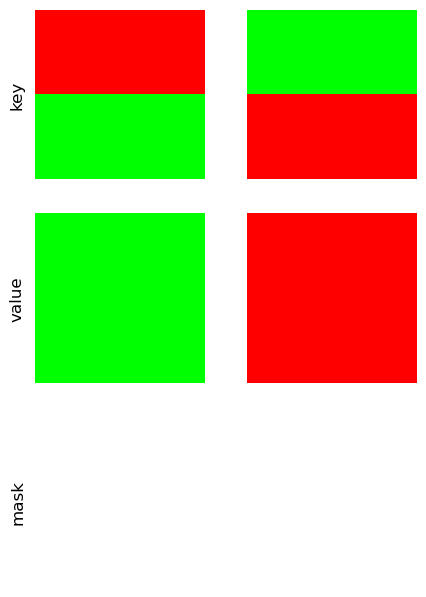

Seed: 0
Editing layer 0
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 40.43it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Found precomputed cov matrices, returning...
n_edit: 2
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([3, 32, 32])
vstar type: <class 'torch.Tensor'> shape: torch.Size([2, 10, 14, 14])
mstar type: <class 'torch.Tensor'> shape: torch.Size([2, 1, 32, 32])
key shape: torch.Size([2, 3, 32, 32]) val shape: torch.Size([2, 10, 14, 14])


tensor(0.5437, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 30000/30000 [00:41<00:00, 721.1


Loss (orig, final): 0.663171648979187 0.5437104105949402
L2 norm of weight change: 2.8126142024993896
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 41.07it/s]

Post-edit metrics: {'TP': array([666, 627, 910, 892, 515,  56, 229, 244, 358,  96]), 'TN': array([8226, 8310, 8091, 7408, 7782, 8645, 8359, 8054, 7353, 8365]), 'FPs': array([ 344,  105,  427, 1132,  786,   13,  233,  468, 1223,  176]), 'FNs': array([264, 458,  72,  68, 417, 786, 679, 734, 566, 863]), 'accuracy': 0.48347368421052633, 'per_class_accuracy': array([0.936     , 0.94073684, 0.94747368, 0.87368421, 0.87336842,
       0.91589474, 0.904     , 0.87347368, 0.81168421, 0.89063158]), 'per_class_accuracy_mean': 0.8966947368421053, 'precision': array([0.65940594, 0.85655738, 0.68062827, 0.44071146, 0.39584935,
       0.8115942 , 0.495671  , 0.34269663, 0.22643896, 0.35294118]), 'precision_mean': 0.5262494365937024, 'recall': array([0.71612903, 0.57788018, 0.92668024, 0.92916667, 0.55257511,
       0.06650831, 0.25220264, 0.24948875, 0.38744589, 0.10010428]), 'recall_mean': 0.47581811069517316, 'predicted_class_distribution': array([1010,  732, 1337, 2024, 1301,   69,  462,  712, 1581

saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_0/results/edit_idx_5
torch.Size([2, 1, 32, 32])
3 2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


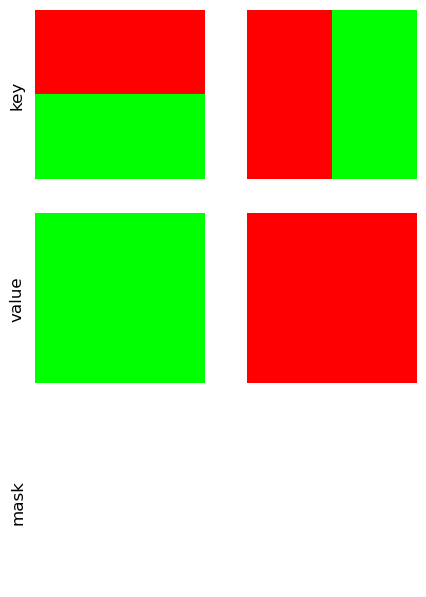

Seed: 0
Editing layer 0
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 39.84it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Found precomputed cov matrices, returning...
n_edit: 2
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([3, 32, 32])
vstar type: <class 'torch.Tensor'> shape: torch.Size([2, 10, 14, 14])
mstar type: <class 'torch.Tensor'> shape: torch.Size([2, 1, 32, 32])
key shape: torch.Size([2, 3, 32, 32]) val shape: torch.Size([2, 10, 14, 14])


tensor(0.5243, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 30000/30000 [00:41<00:00, 727.5

Loss (orig, final): 0.6250613927841187 0.5243330001831055
L2 norm of weight change: 5.776474952697754
Performing post-edit metric calculations on validation set.



100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 40.52it/s]

Post-edit metrics: {'TP': array([ 747, 1069,  846,  847,  887,   34,   11,   40,    8,    3]), 'TN': array([7820, 7890, 7654, 7376, 7097, 8655, 8527, 8499, 8487, 8487]), 'FPs': array([ 750,  525,  864, 1164, 1471,    3,   65,   23,   89,   54]), 'FNs': array([183,  16, 136, 113,  45, 808, 897, 938, 916, 956]), 'accuracy': 0.4728421052631579, 'per_class_accuracy': array([0.90178947, 0.94305263, 0.89473684, 0.86557895, 0.84042105,
       0.91463158, 0.89873684, 0.89884211, 0.89421053, 0.89368421]), 'per_class_accuracy_mean': 0.8945684210526317, 'precision': array([0.498998  , 0.6706399 , 0.49473684, 0.42118349, 0.37616624,
       0.91891892, 0.14473684, 0.63492063, 0.08247423, 0.05263158]), 'precision_mean': 0.4295406672796197, 'recall': array([0.80322581, 0.98525346, 0.86150713, 0.88229167, 0.95171674,
       0.04038005, 0.01211454, 0.0408998 , 0.00865801, 0.00312826]), 'recall_mean': 0.458917544355909, 'predicted_class_distribution': array([1497, 1594, 1710, 2011, 2358,   37,   76,   6

(0324_170704) Starting Trial 7/16...
saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_0/results/edit_idx_6
torch.Size([2, 1, 32, 32])
3 2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


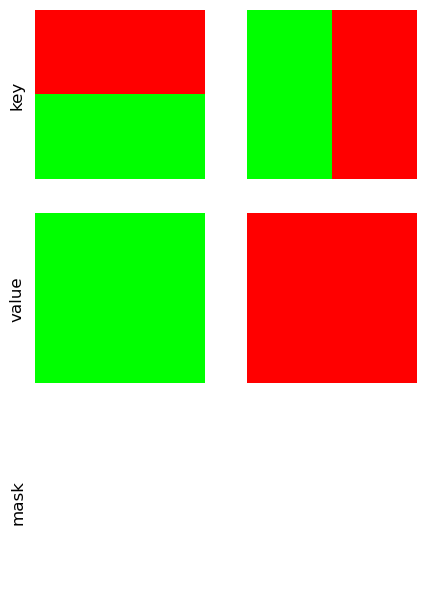

Seed: 0
Editing layer 0
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 40.17it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Saved pre-edit logits to saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_0/results/edit_idx_6/models/pre_edit_logits.pth
Created <class 'trainer.editor.EditorEAC'> editor.
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/2_Spurious_MNIST_hold_out/lenet-0
Found precomputed cov matrices, returning...
n_edit: 2
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([3, 32, 32])
vstar type: <class 'torch.Tensor'> shape: torch.Size([2, 10, 14, 14])
mstar type: <class 'torch.Tensor'> shape: torch.Size([2, 1, 32, 32])
key shape: torch.Size([2, 3, 32, 32]) val shape: torch.Size([2, 10, 14, 14])


tensor(0.5064, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 30000/30000 [00:41<00:00, 724.8

Loss (orig, final): 0.6271398067474365 0.5064427256584167
L2 norm of weight change: 5.456079959869385
Performing post-edit metric calculations on validation set.



100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 39.87it/s]

Post-edit metrics: {'TP': array([ 898, 1068,  908,  921,  867,    0,    9,   38,    6,    1]), 'TN': array([7807, 8114, 7885, 7135, 6903, 8658, 8591, 8522, 8561, 8540]), 'FPs': array([ 763,  301,  633, 1405, 1665,    0,    1,    0,   15,    1]), 'FNs': array([ 32,  17,  74,  39,  65, 842, 899, 940, 918, 958]), 'accuracy': 0.49642105263157893, 'per_class_accuracy': array([0.91631579, 0.96652632, 0.92557895, 0.848     , 0.81789474,
       0.91136842, 0.90526316, 0.90105263, 0.90178947, 0.89905263]), 'per_class_accuracy_mean': 0.8992842105263158, 'precision': array([0.54063817, 0.78013148, 0.58922777, 0.39595873, 0.34241706,
       0.        , 0.9       , 1.        , 0.28571429, 0.5       ]), 'precision_mean': 0.5334087501538767, 'recall': array([0.9655914 , 0.9843318 , 0.92464358, 0.959375  , 0.93025751,
       0.        , 0.00991189, 0.03885481, 0.00649351, 0.00104275]), 'recall_mean': 0.482050224969566, 'predicted_class_distribution': array([1661, 1369, 1541, 2326, 2532,    0,   10,   


/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_0/results/edit_idx_7
torch.Size([2, 1, 32, 32])
3 2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


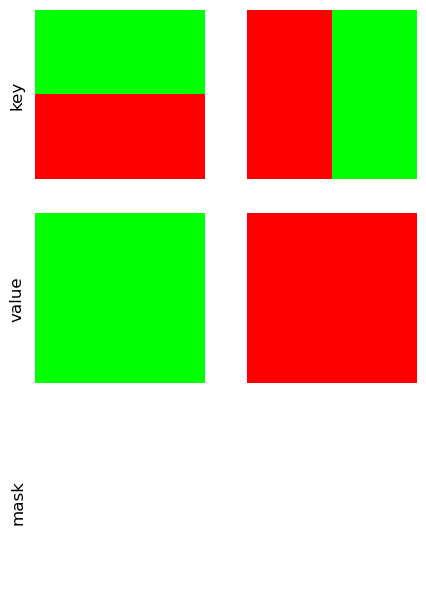

Seed: 0
Editing layer 0
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 40.93it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Found precomputed cov matrices, returning...
n_edit: 2
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([3, 32, 32])
vstar type: <class 'torch.Tensor'> shape: torch.Size([2, 10, 14, 14])
mstar type: <class 'torch.Tensor'> shape: torch.Size([2, 1, 32, 32])
key shape: torch.Size([2, 3, 32, 32]) val shape: torch.Size([2, 10, 14, 14])


tensor(0.5742, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 30000/30000 [00:41<00:00, 723.7

Loss (orig, final): 0.6096300482749939 0.5742378830909729
L2 norm of weight change: 5.887484550476074
Performing post-edit metric calculations on validation set.



100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 41.20it/s]

Post-edit metrics: {'TP': array([796, 784, 764, 879, 693,  28,  97, 428, 126,  79]), 'TN': array([7772, 8294, 7943, 7151, 7294, 8653, 8584, 8011, 8473, 8499]), 'FPs': array([ 798,  121,  575, 1389, 1274,    5,    8,  511,  103,   42]), 'FNs': array([134, 301, 218,  81, 239, 814, 811, 550, 798, 880]), 'accuracy': 0.492, 'per_class_accuracy': array([0.90189474, 0.95557895, 0.91652632, 0.84526316, 0.84073684,
       0.91378947, 0.91378947, 0.88831579, 0.90515789, 0.90294737]), 'per_class_accuracy_mean': 0.8984, 'precision': array([0.49937265, 0.86629834, 0.57057506, 0.38756614, 0.35231317,
       0.84848485, 0.92380952, 0.45580405, 0.55021834, 0.65289256]), 'precision_mean': 0.6107334672554721, 'recall': array([0.85591398, 0.72258065, 0.77800407, 0.915625  , 0.74356223,
       0.03325416, 0.10682819, 0.43762781, 0.13636364, 0.08237748]), 'recall_mean': 0.481213720410016, 'predicted_class_distribution': array([1594,  905, 1339, 2268, 1967,   33,  105,  939,  229,  121]), 'f1': array([0.630

saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_0/results/edit_idx_8
torch.Size([2, 1, 32, 32])
3 2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


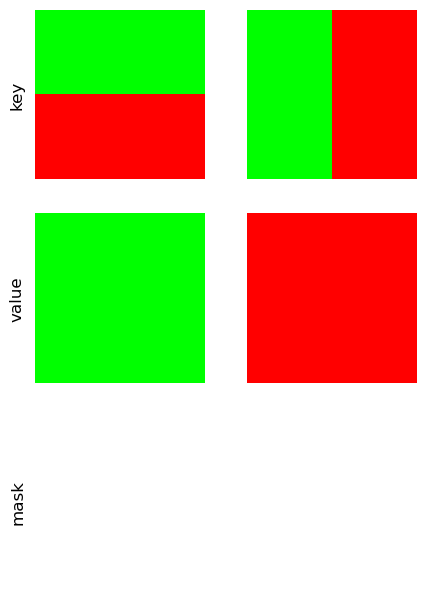

Seed: 0
Editing layer 0
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 39.51it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Found precomputed cov matrices, returning...
n_edit: 2
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([3, 32, 32])
vstar type: <class 'torch.Tensor'> shape: torch.Size([2, 10, 14, 14])
mstar type: <class 'torch.Tensor'> shape: torch.Size([2, 1, 32, 32])
key shape: torch.Size([2, 3, 32, 32]) val shape: torch.Size([2, 10, 14, 14])


tensor(0.5693, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 30000/30000 [00:41<00:00, 722.8

Loss (orig, final): 0.6117084622383118 0.5693033933639526
L2 norm of weight change: 6.147644996643066
Performing post-edit metric calculations on validation set.



100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 40.11it/s]

Post-edit metrics: {'TP': array([ 782, 1077,  873,  652,  873,  159,   68,  137,   42,    6]), 'TN': array([8129, 7857, 7744, 7513, 7166, 8472, 8581, 8288, 8451, 8468]), 'FPs': array([ 441,  558,  774, 1027, 1402,  186,   11,  234,  125,   73]), 'FNs': array([148,   8, 109, 308,  59, 683, 840, 841, 882, 953]), 'accuracy': 0.49147368421052634, 'per_class_accuracy': array([0.938     , 0.94042105, 0.90705263, 0.85947368, 0.84621053,
       0.90852632, 0.91042105, 0.88684211, 0.894     , 0.892     ]), 'per_class_accuracy_mean': 0.8982947368421051, 'precision': array([0.63941128, 0.6587156 , 0.53005464, 0.38832638, 0.38373626,
       0.46086957, 0.86075949, 0.36927224, 0.25149701, 0.07594937]), 'precision_mean': 0.4618591842518322, 'recall': array([0.84086022, 0.99262673, 0.88900204, 0.67916667, 0.93669528,
       0.1888361 , 0.07488987, 0.1400818 , 0.04545455, 0.00625652]), 'recall_mean': 0.47938697600663077, 'predicted_class_distribution': array([1223, 1635, 1647, 1679, 2275,  345,   79, 

saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_0/results/edit_idx_9
torch.Size([2, 1, 32, 32])
3 2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


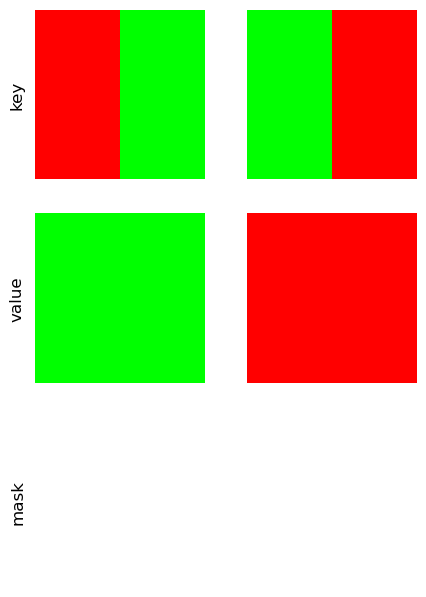

Seed: 0
Editing layer 0
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 40.33it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Found precomputed cov matrices, returning...
n_edit: 2
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([3, 32, 32])
vstar type: <class 'torch.Tensor'> shape: torch.Size([2, 10, 14, 14])
mstar type: <class 'torch.Tensor'> shape: torch.Size([2, 1, 32, 32])
key shape: torch.Size([2, 3, 32, 32]) val shape: torch.Size([2, 10, 14, 14])


tensor(0.5608, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 30000/30000 [00:40<00:00, 745.8

Loss (orig, final): 0.6189944744110107 0.5608171820640564
L2 norm of weight change: 2.1607680320739746
Performing post-edit metric calculations on validation set.



100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 43.68it/s]

Post-edit metrics: {'TP': array([ 589, 1063,  535,  497,  707,  413,  416,  404,  401,  229]), 'TN': array([8237, 8204, 8229, 7723, 7550, 8155, 8490, 8356, 8030, 8280]), 'FPs': array([ 333,  211,  289,  817, 1018,  503,  102,  166,  546,  261]), 'FNs': array([341,  22, 447, 463, 225, 429, 492, 574, 523, 730]), 'accuracy': 0.5530526315789474, 'per_class_accuracy': array([0.92905263, 0.97547368, 0.92252632, 0.86526316, 0.86915789,
       0.90189474, 0.93747368, 0.92210526, 0.88747368, 0.89568421]), 'per_class_accuracy_mean': 0.9106105263157895, 'precision': array([0.63882863, 0.83437991, 0.64927184, 0.3782344 , 0.40985507,
       0.45087336, 0.8030888 , 0.70877193, 0.42344245, 0.46734694]), 'precision_mean': 0.5764093339096318, 'recall': array([0.63333333, 0.9797235 , 0.54480652, 0.51770833, 0.75858369,
       0.49049881, 0.45814978, 0.41308793, 0.43398268, 0.23879041]), 'recall_mean': 0.5468664994573403, 'predicted_class_distribution': array([ 922, 1274,  824, 1314, 1725,  916,  518,  5

(0324_170957) Starting Trial 11/16...
saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_0/results/edit_idx_10
torch.Size([2, 1, 32, 32])
3 2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


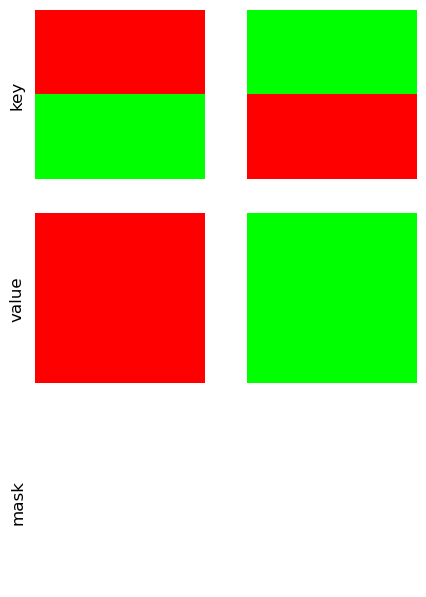

Seed: 0
Editing layer 0
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 41.66it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Found precomputed cov matrices, returning...
n_edit: 2
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([3, 32, 32])
vstar type: <class 'torch.Tensor'> shape: torch.Size([2, 10, 14, 14])
mstar type: <class 'torch.Tensor'> shape: torch.Size([2, 1, 32, 32])
key shape: torch.Size([2, 3, 32, 32]) val shape: torch.Size([2, 10, 14, 14])


tensor(0.5183, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 30000/30000 [00:42<00:00, 710.6


Loss (orig, final): 0.6339172124862671 0.5182713270187378
L2 norm of weight change: 2.70475172996521
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 42.41it/s]

Post-edit metrics: {'TP': array([881, 580, 946, 903, 871,   2, 221, 232, 114,  75]), 'TN': array([7753, 8310, 7933, 7204, 7499, 8654, 8552, 8015, 8432, 8473]), 'FPs': array([ 817,  105,  585, 1336, 1069,    4,   40,  507,  144,   68]), 'FNs': array([ 49, 505,  36,  57,  61, 840, 687, 746, 810, 884]), 'accuracy': 0.5078947368421053, 'per_class_accuracy': array([0.90884211, 0.93578947, 0.93463158, 0.85336842, 0.88105263,
       0.91115789, 0.92347368, 0.86810526, 0.89957895, 0.89978947]), 'per_class_accuracy_mean': 0.901578947368421, 'precision': array([0.5188457 , 0.84671533, 0.6178968 , 0.40330505, 0.44896907,
       0.33333333, 0.8467433 , 0.31393775, 0.44186047, 0.52447552]), 'precision_mean': 0.5296082319495541, 'recall': array([0.94731183, 0.53456221, 0.96334012, 0.940625  , 0.93454936,
       0.0023753 , 0.24339207, 0.23721881, 0.12337662, 0.07820647]), 'recall_mean': 0.5004957788108353, 'predicted_class_distribution': array([1698,  685, 1531, 2239, 1940,    6,  261,  739,  258,  

saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_0/results/edit_idx_11
torch.Size([2, 1, 32, 32])
3 2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


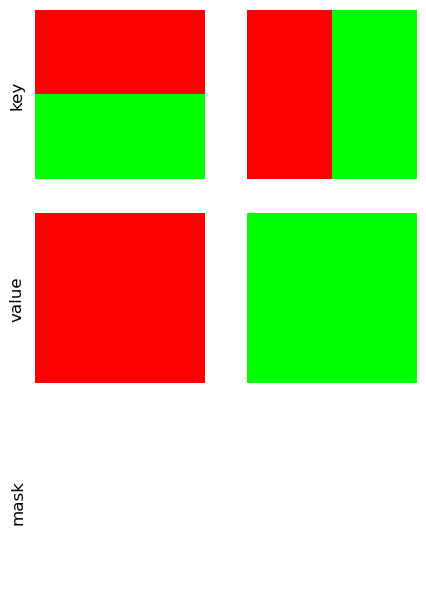

Seed: 0
Editing layer 0
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 42.73it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Saved pre-edit logits to saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_0/results/edit_idx_11/models/pre_edit_logits.pth
Created <class 'trainer.editor.EditorEAC'> editor.
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/2_Spurious_MNIST_hold_out/lenet-0
Found precomputed cov matrices, returning...
n_edit: 2
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([3, 32, 32])
vstar type: <class 'torch.Tensor'> shape: torch.Size([2, 10, 14, 14])
mstar type: <class 'torch.Tensor'> shape: torch.Size([2, 1, 32, 32])
key shape: torch.Size([2, 3, 32, 32]) val shape: torch.Size([2, 10, 14, 14])


tensor(0.5262, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 30000/30000 [00:39<00:00, 755.0

Loss (orig, final): 0.6412032246589661 0.52619868516922
L2 norm of weight change: 5.270170211791992
Performing post-edit metric calculations on validation set.



100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 40.74it/s]

Post-edit metrics: {'TP': array([ 865, 1082,  842,  680,  916,   15,   81,   13,    7,    0]), 'TN': array([8014, 7628, 7544, 7571, 6931, 8652, 8549, 8522, 8557, 8533]), 'FPs': array([ 556,  787,  974,  969, 1637,    6,   43,    0,   19,    8]), 'FNs': array([ 65,   3, 140, 280,  16, 827, 827, 965, 917, 959]), 'accuracy': 0.47378947368421054, 'per_class_accuracy': array([0.93463158, 0.91684211, 0.88273684, 0.86852632, 0.826     ,
       0.91231579, 0.90842105, 0.89842105, 0.90147368, 0.89821053]), 'per_class_accuracy_mean': 0.894757894736842, 'precision': array([0.60872625, 0.57891921, 0.46365639, 0.41237113, 0.35879358,
       0.71428571, 0.65322581, 1.        , 0.26923077, 0.        ]), 'precision_mean': 0.5059208845091823, 'recall': array([0.93010753, 0.99723502, 0.85743381, 0.70833333, 0.98283262,
       0.01781473, 0.08920705, 0.01329243, 0.00757576, 0.        ]), 'recall_mean': 0.4603832276248846, 'predicted_class_distribution': array([1421, 1869, 1816, 1649, 2553,   21,  124,   


/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_0/results/edit_idx_12
torch.Size([2, 1, 32, 32])
3 2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


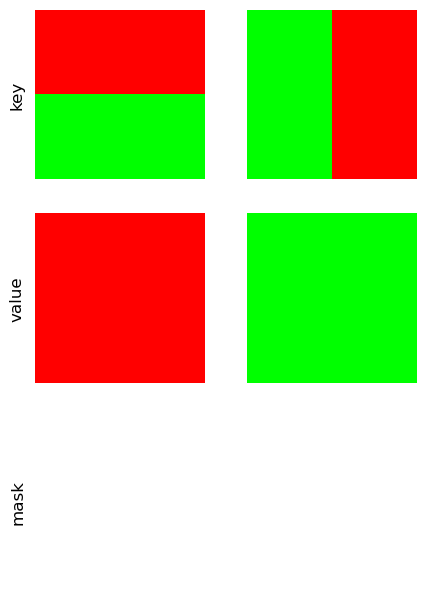

Seed: 0
Editing layer 0
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 41.25it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Found precomputed cov matrices, returning...
n_edit: 2
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([3, 32, 32])
vstar type: <class 'torch.Tensor'> shape: torch.Size([2, 10, 14, 14])
mstar type: <class 'torch.Tensor'> shape: torch.Size([2, 1, 32, 32])
key shape: torch.Size([2, 3, 32, 32]) val shape: torch.Size([2, 10, 14, 14])


tensor(0.5067, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 30000/30000 [00:40<00:00, 743.4

Loss (orig, final): 0.5883660316467285 0.5067311525344849
L2 norm of weight change: 4.718273639678955
Performing post-edit metric calculations on validation set.



100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 41.41it/s]

Post-edit metrics: {'TP': array([762, 635, 810, 904, 767,   9, 139, 277,  43, 129]), 'TN': array([7348, 8303, 7788, 6995, 7363, 8654, 8529, 8487, 8488, 8520]), 'FPs': array([1222,  112,  730, 1545, 1205,    4,   63,   35,   88,   21]), 'FNs': array([168, 450, 172,  56, 165, 833, 769, 701, 881, 830]), 'accuracy': 0.4710526315789474, 'per_class_accuracy': array([0.85368421, 0.94084211, 0.90505263, 0.83147368, 0.85578947,
       0.91189474, 0.91242105, 0.92252632, 0.898     , 0.91042105]), 'per_class_accuracy_mean': 0.8942105263157893, 'precision': array([0.38407258, 0.85006693, 0.52597403, 0.36913026, 0.38894523,
       0.69230769, 0.68811881, 0.88782051, 0.32824427, 0.86      ]), 'precision_mean': 0.59746803233556, 'recall': array([0.81935484, 0.58525346, 0.82484725, 0.94166667, 0.82296137,
       0.01068884, 0.1530837 , 0.28323108, 0.0465368 , 0.13451512]), 'recall_mean': 0.4622139122340264, 'predicted_class_distribution': array([1984,  747, 1540, 2449, 1972,   13,  202,  312,  131,  1

(0324_171206) Starting Trial 14/16...
saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_0/results/edit_idx_13
torch.Size([2, 1, 32, 32])
3 2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


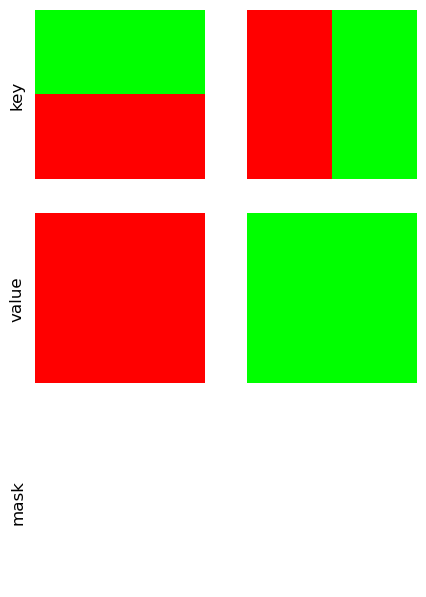

Seed: 0
Editing layer 0
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 42.24it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Found precomputed cov matrices, returning...
n_edit: 2
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([3, 32, 32])
vstar type: <class 'torch.Tensor'> shape: torch.Size([2, 10, 14, 14])
mstar type: <class 'torch.Tensor'> shape: torch.Size([2, 1, 32, 32])
key shape: torch.Size([2, 3, 32, 32]) val shape: torch.Size([2, 10, 14, 14])


tensor(0.5150, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 30000/30000 [00:40<00:00, 734.1

Loss (orig, final): 0.655026376247406 0.5150063037872314
L2 norm of weight change: 6.035783290863037
Performing post-edit metric calculations on validation set.



100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 38.91it/s]

Post-edit metrics: {'TP': array([ 890, 1058,  897,  913,  827,   10,   43,  192,   64,    0]), 'TN': array([7807, 8187, 7947, 7253, 6967, 8653, 8588, 8466, 8532, 8494]), 'FPs': array([ 763,  228,  571, 1287, 1601,    5,    4,   56,   44,   47]), 'FNs': array([ 40,  27,  85,  47, 105, 832, 865, 786, 860, 959]), 'accuracy': 0.5151578947368421, 'per_class_accuracy': array([0.91547368, 0.97315789, 0.93094737, 0.85957895, 0.82042105,
       0.91189474, 0.90852632, 0.91136842, 0.90484211, 0.89410526]), 'per_class_accuracy_mean': 0.9030315789473684, 'precision': array([0.538415  , 0.82270607, 0.61103542, 0.415     , 0.34060956,
       0.66666667, 0.91489362, 0.77419355, 0.59259259, 0.        ]), 'precision_mean': 0.5676112470544035, 'recall': array([0.95698925, 0.97511521, 0.91344196, 0.95104167, 0.88733906,
       0.01187648, 0.04735683, 0.19631902, 0.06926407, 0.        ]), 'recall_mean': 0.5008743532762621, 'predicted_class_distribution': array([1653, 1286, 1468, 2200, 2428,   15,   47,  2


/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_0/results/edit_idx_14
torch.Size([2, 1, 32, 32])
3 2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


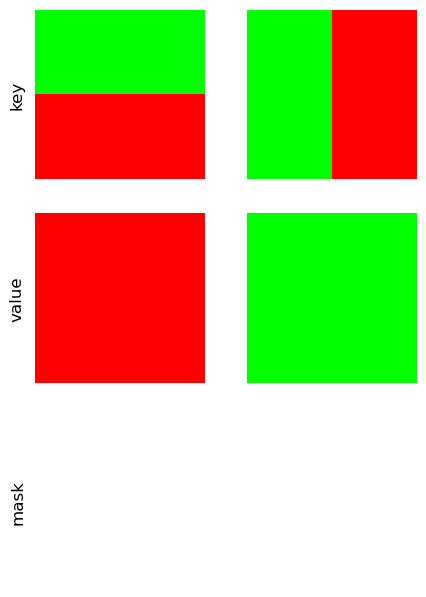

Seed: 0
Editing layer 0
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 41.15it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Found precomputed cov matrices, returning...
n_edit: 2
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([3, 32, 32])
vstar type: <class 'torch.Tensor'> shape: torch.Size([2, 10, 14, 14])
mstar type: <class 'torch.Tensor'> shape: torch.Size([2, 1, 32, 32])
key shape: torch.Size([2, 3, 32, 32]) val shape: torch.Size([2, 10, 14, 14])


tensor(0.5334, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 30000/30000 [00:42<00:00, 707.7

Loss (orig, final): 0.6021892428398132 0.5334000587463379
L2 norm of weight change: 6.193104267120361
Performing post-edit metric calculations on validation set.



100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 40.46it/s]

Post-edit metrics: {'TP': array([ 635, 1011,  859,  828,  674,  141,    6,  175,    3,   15]), 'TN': array([8183, 8012, 7402, 7145, 7574, 8592, 8569, 7985, 8428, 8457]), 'FPs': array([ 387,  403, 1116, 1395,  994,   66,   23,  537,  148,   84]), 'FNs': array([295,  74, 123, 132, 258, 701, 902, 803, 921, 944]), 'accuracy': 0.45757894736842103, 'per_class_accuracy': array([0.92821053, 0.94978947, 0.86957895, 0.83926316, 0.86821053,
       0.91926316, 0.90263158, 0.85894737, 0.88747368, 0.89178947]), 'per_class_accuracy_mean': 0.8915157894736844, 'precision': array([0.62133072, 0.71499293, 0.43493671, 0.37246964, 0.40407674,
       0.68115942, 0.20689655, 0.24578652, 0.01986755, 0.15151515]), 'precision_mean': 0.38530319250840184, 'recall': array([0.6827957 , 0.93179724, 0.87474542, 0.8625    , 0.72317597,
       0.16745843, 0.00660793, 0.17893661, 0.00324675, 0.01564129]), 'recall_mean': 0.4446905330525023, 'predicted_class_distribution': array([1022, 1414, 1975, 2223, 1668,  207,   29, 

saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_0/results/edit_idx_15
torch.Size([2, 1, 32, 32])
3 2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


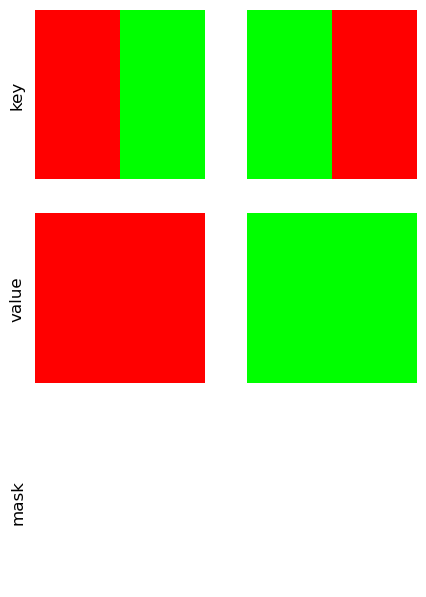

Seed: 0
Editing layer 0
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 40.25it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Found precomputed cov matrices, returning...
n_edit: 2
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([3, 32, 32])
vstar type: <class 'torch.Tensor'> shape: torch.Size([2, 10, 14, 14])
mstar type: <class 'torch.Tensor'> shape: torch.Size([2, 1, 32, 32])
key shape: torch.Size([2, 3, 32, 32]) val shape: torch.Size([2, 10, 14, 14])


tensor(0.5489, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 30000/30000 [00:41<00:00, 724.1

Loss (orig, final): 0.5640789270401001 0.5489380359649658
L2 norm of weight change: 1.6787139177322388
Performing post-edit metric calculations on validation set.



100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 40.29it/s]

Post-edit metrics: {'TP': array([450, 747, 520, 506, 453, 422, 415, 462, 441, 429]), 'TN': array([8248, 8292, 8231, 7696, 7770, 7930, 8231, 8390, 7909, 8148]), 'FPs': array([322, 123, 287, 844, 798, 728, 361, 132, 667, 393]), 'FNs': array([480, 338, 462, 454, 479, 420, 493, 516, 483, 530]), 'accuracy': 0.51, 'per_class_accuracy': array([0.91557895, 0.95147368, 0.92115789, 0.86336842, 0.86557895,
       0.87915789, 0.91010526, 0.93178947, 0.87894737, 0.90284211]), 'per_class_accuracy_mean': 0.9019999999999999, 'precision': array([0.58290155, 0.85862069, 0.64436183, 0.37481481, 0.36211031,
       0.36695652, 0.53479381, 0.77777778, 0.39801444, 0.52189781]), 'precision_mean': 0.5422249569179733, 'recall': array([0.48387097, 0.68847926, 0.52953157, 0.52708333, 0.4860515 ,
       0.50118765, 0.45704846, 0.47239264, 0.47727273, 0.44734098]), 'recall_mean': 0.5070259086225178, 'predicted_class_distribution': array([ 772,  870,  807, 1350, 1251, 1150,  776,  594, 1108,  822]), 'f1': array([0.5

All metrics and KNN results can be found in saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_0/results/edit_idx_15/models
Experimenting with layernum of 1
(0324_171418) Starting Trial 1/16...
saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_0
torch.Size([2, 1, 32, 32])
3 2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


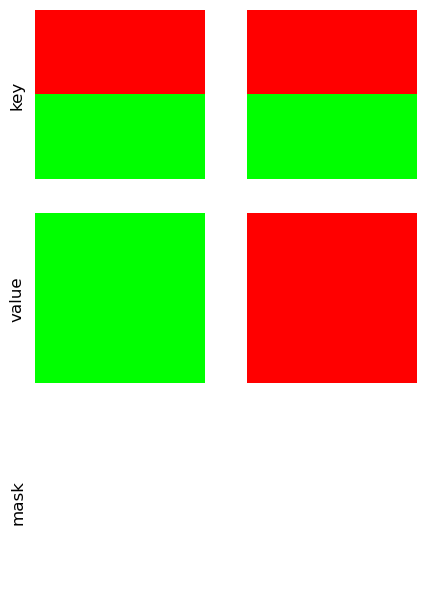

Seed: 0
Editing layer 1
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 39.84it/s]


Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

tensor(6.1800, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 30000/30000 [00:40<00:00, 749.6


Loss (orig, final): 1.2750283479690552 6.17997407913208
L2 norm of weight change: 432.1958312988281
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 42.38it/s]

Post-edit metrics: {'TP': array([ 49, 640, 478, 178, 351, 273,  12, 338,  47,  32]), 'TN': array([8339, 7798, 6710, 7982, 7113, 7111, 8492, 7985, 8440, 8428]), 'FPs': array([ 231,  617, 1808,  558, 1455, 1547,  100,  537,  136,  113]), 'FNs': array([881, 445, 504, 782, 581, 569, 896, 640, 877, 927]), 'accuracy': 0.25242105263157893, 'per_class_accuracy': array([0.88294737, 0.88821053, 0.75663158, 0.85894737, 0.78568421,
       0.77726316, 0.89515789, 0.87610526, 0.89336842, 0.89052632]), 'per_class_accuracy_mean': 0.8504842105263158, 'precision': array([0.175     , 0.50914877, 0.20909886, 0.24184783, 0.19435216,
       0.15      , 0.10714286, 0.38628571, 0.2568306 , 0.22068966]), 'precision_mean': 0.24503964427967762, 'recall': array([0.05268817, 0.58986175, 0.48676171, 0.18541667, 0.37660944,
       0.32422803, 0.01321586, 0.34560327, 0.0508658 , 0.03336809]), 'recall_mean': 0.24586187948622276, 'predicted_class_distribution': array([ 280, 1257, 2286,  736, 1806, 1820,  112,  875,  18

Saved post-edit metrics saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_0/models/post_edit_metrics.pth
Saved post-edit logits to saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_0/models/post_edit_logits.pth
All metrics and KNN results can be found in saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_0/models
(0324_171501) Starting Trial 2/16...
saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_1
torch.Size([2, 1, 32, 32])
3 2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data 

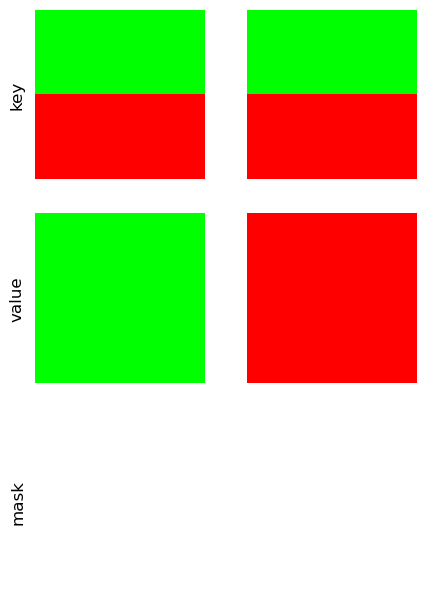

Seed: 0
Editing layer 1
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 42.34it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Found precomputed cov matrices, returning...
n_edit: 2
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([10, 14, 14])
vstar type: <class 'torch.Tensor'> shape: torch.Size([2, 20, 5, 5])
mstar type: <class 'torch.Tensor'> shape: torch.Size([2, 1, 32, 32])
key shape: torch.Size([2, 10, 14, 14]) val shape: torch.Size([2, 20, 5, 5])


tensor(0.8004, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 30000/30000 [00:36<00:00, 814.4

Loss (orig, final): 1.456160068511963 0.8003509640693665
L2 norm of weight change: 4.748870849609375
Performing post-edit metric calculations on validation set.



100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 43.46it/s]

Post-edit metrics: {'TP': array([450, 538, 521, 494, 452, 420, 434, 479, 455, 452]), 'TN': array([8264, 8293, 8174, 7832, 7695, 8251, 8365, 8027, 7834, 7960]), 'FPs': array([306, 122, 344, 708, 873, 407, 227, 495, 742, 581]), 'FNs': array([480, 547, 461, 466, 480, 422, 474, 499, 469, 507]), 'accuracy': 0.4942105263157895, 'per_class_accuracy': array([0.91726316, 0.92957895, 0.91526316, 0.87642105, 0.85757895,
       0.91273684, 0.92621053, 0.89536842, 0.87252632, 0.88547368]), 'per_class_accuracy_mean': 0.8988421052631578, 'precision': array([0.5952381 , 0.81515152, 0.60231214, 0.4109817 , 0.34113208,
       0.50785973, 0.65658094, 0.49178645, 0.38011696, 0.4375605 ]), 'precision_mean': 0.5238720103803137, 'recall': array([0.48387097, 0.49585253, 0.5305499 , 0.51458333, 0.48497854,
       0.49881235, 0.47797357, 0.48977505, 0.49242424, 0.4713243 ]), 'recall_mean': 0.49401447840937013, 'predicted_class_distribution': array([ 756,  660,  865, 1202, 1325,  827,  661,  974, 1197, 1033]), '

saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_2
torch.Size([2, 1, 32, 32])
3 2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


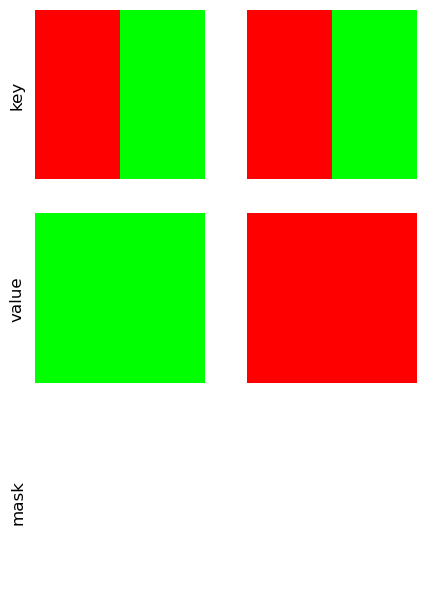

Seed: 0
Editing layer 1
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 43.30it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Found precomputed cov matrices, returning...
n_edit: 2
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([10, 14, 14])
vstar type: <class 'torch.Tensor'> shape: torch.Size([2, 20, 5, 5])
mstar type: <class 'torch.Tensor'> shape: torch.Size([2, 1, 32, 32])
key shape: torch.Size([2, 10, 14, 14]) val shape: torch.Size([2, 20, 5, 5])


tensor(14.9387, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 30000/30000 [00:39<00:00, 762.

Loss (orig, final): 1.0019233226776123 14.93868637084961
L2 norm of weight change: 1833.883056640625
Performing post-edit metric calculations on validation set.



100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 39.78it/s]

Post-edit metrics: {'TP': array([  73, 1067,  114,  217,  289,    1,    5,    0,    0,    0]), 'TN': array([7629, 5089, 8123, 8025, 6350, 8621, 8486, 8418, 8489, 8536]), 'FPs': array([ 941, 3326,  395,  515, 2218,   37,  106,  104,   87,    5]), 'FNs': array([857,  18, 868, 743, 643, 841, 903, 978, 924, 959]), 'accuracy': 0.18589473684210525, 'per_class_accuracy': array([0.81073684, 0.648     , 0.86705263, 0.86757895, 0.69884211,
       0.90757895, 0.89378947, 0.88610526, 0.89357895, 0.89852632]), 'per_class_accuracy_mean': 0.8371789473684211, 'precision': array([0.07199211, 0.24288641, 0.22396857, 0.29644809, 0.11527722,
       0.02631579, 0.04504505, 0.        , 0.        , 0.        ]), 'precision_mean': 0.10219332321908729, 'recall': array([0.07849462, 0.98341014, 0.11608961, 0.22604167, 0.31008584,
       0.00118765, 0.00550661, 0.        , 0.        , 0.        ]), 'recall_mean': 0.17208161349014955, 'predicted_class_distribution': array([1014, 4393,  509,  732, 2507,   38,  111,


/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_3
torch.Size([2, 1, 32, 32])
3 2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


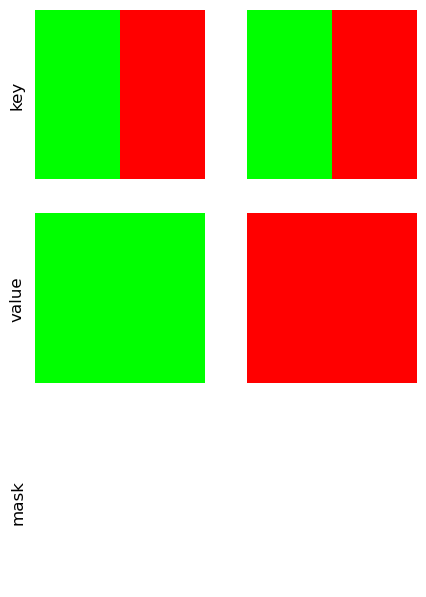

Seed: 0
Editing layer 1
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 42.32it/s]


Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

tensor(2.3110, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 30000/30000 [00:39<00:00, 768.8

Loss (orig, final): 0.79411381483078 2.311023235321045
L2 norm of weight change: 814.9749145507812
Performing post-edit metric calculations on validation set.



100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 38.90it/s]

Post-edit metrics: {'TP': array([378,  62,  40,  15, 483,  11,   5, 119, 122,   8]), 'TN': array([6962, 8268, 7917, 8431, 4431, 8528, 8562, 8169, 7565, 8410]), 'FPs': array([1608,  147,  601,  109, 4137,  130,   30,  353, 1011,  131]), 'FNs': array([ 552, 1023,  942,  945,  449,  831,  903,  859,  802,  951]), 'accuracy': 0.1308421052631579, 'per_class_accuracy': array([0.77263158, 0.87684211, 0.83757895, 0.88905263, 0.51726316,
       0.89884211, 0.90178947, 0.87242105, 0.80915789, 0.88610526]), 'per_class_accuracy_mean': 0.8261684210526316, 'precision': array([0.19033233, 0.29665072, 0.0624025 , 0.12096774, 0.10454545,
       0.07801418, 0.14285714, 0.25211864, 0.10767873, 0.05755396]), 'precision_mean': 0.14131213937627068, 'recall': array([0.40645161, 0.05714286, 0.0407332 , 0.015625  , 0.51824034,
       0.01306413, 0.00550661, 0.12167689, 0.13203463, 0.00834202]), 'recall_mean': 0.131881729848661, 'predicted_class_distribution': array([1986,  209,  641,  124, 4620,  141,   35,  4

saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_4
torch.Size([2, 1, 32, 32])
3 2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


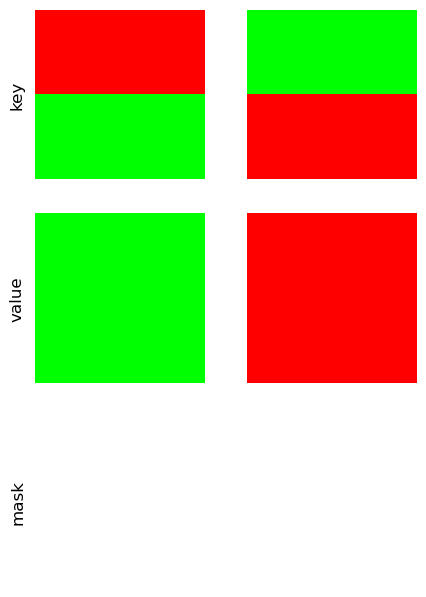

Seed: 0
Editing layer 1
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 39.00it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Found precomputed cov matrices, returning...
n_edit: 2
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([10, 14, 14])
vstar type: <class 'torch.Tensor'> shape: torch.Size([2, 20, 5, 5])
mstar type: <class 'torch.Tensor'> shape: torch.Size([2, 1, 32, 32])
key shape: torch.Size([2, 10, 14, 14]) val shape: torch.Size([2, 20, 5, 5])


tensor(1.1273, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 30000/30000 [00:39<00:00, 761.8

Loss (orig, final): 1.3404861688613892 1.12726628780365
L2 norm of weight change: 6.831904411315918
Performing post-edit metric calculations on validation set.



100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 41.12it/s]

Post-edit metrics: {'TP': array([450, 538, 521, 496, 454, 420, 421, 473, 455, 457]), 'TN': array([8292, 8327, 8223, 7679, 7738, 8266, 8508, 8245, 7455, 7952]), 'FPs': array([ 278,   88,  295,  861,  830,  392,   84,  277, 1121,  589]), 'FNs': array([480, 547, 461, 464, 478, 422, 487, 505, 469, 502]), 'accuracy': 0.49315789473684213, 'per_class_accuracy': array([0.92021053, 0.93315789, 0.92042105, 0.86052632, 0.86231579,
       0.91431579, 0.93989474, 0.91768421, 0.83263158, 0.88515789]), 'per_class_accuracy_mean': 0.8986315789473686, 'precision': array([0.61813187, 0.85942492, 0.63848039, 0.36551216, 0.35358255,
       0.51724138, 0.83366337, 0.63066667, 0.28870558, 0.43690249]), 'precision_mean': 0.5542311375837955, 'recall': array([0.48387097, 0.49585253, 0.5305499 , 0.51666667, 0.48712446,
       0.49881235, 0.46365639, 0.48364008, 0.49242424, 0.47653806]), 'recall_mean': 0.4929135654569775, 'predicted_class_distribution': array([ 728,  626,  816, 1357, 1284,  812,  505,  750, 1576,

saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_5
torch.Size([2, 1, 32, 32])
3 2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


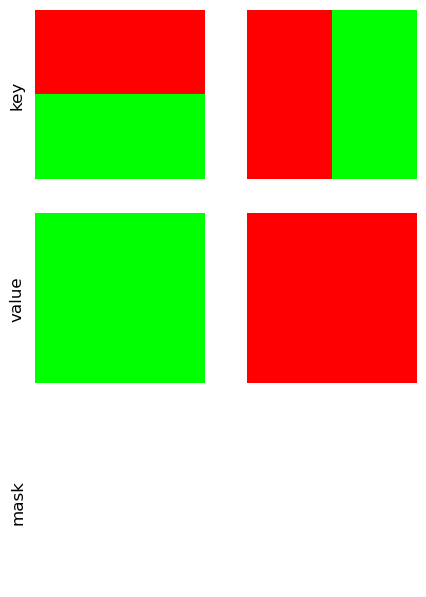

Seed: 0
Editing layer 1
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 22.29it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Found precomputed cov matrices, returning...
n_edit: 2
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([10, 14, 14])
vstar type: <class 'torch.Tensor'> shape: torch.Size([2, 20, 5, 5])
mstar type: <class 'torch.Tensor'> shape: torch.Size([2, 1, 32, 32])
key shape: torch.Size([2, 10, 14, 14]) val shape: torch.Size([2, 20, 5, 5])


tensor(1.3990, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 30000/30000 [00:39<00:00, 768.2


Loss (orig, final): 1.0980747938156128 1.3989628553390503
L2 norm of weight change: 361.12774658203125
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 41.27it/s]

Post-edit metrics: {'TP': array([ 37,   5, 887, 298, 307,   6,   0,  13,   0,   0]), 'TN': array([8469, 8414, 4073, 6715, 7004, 8651, 8592, 8518, 8576, 8541]), 'FPs': array([ 101,    1, 4445, 1825, 1564,    7,    0,    4,    0,    0]), 'FNs': array([ 893, 1080,   95,  662,  625,  836,  908,  965,  924,  959]), 'accuracy': 0.16347368421052633, 'per_class_accuracy': array([0.89536842, 0.88621053, 0.52210526, 0.73821053, 0.76957895,
       0.91126316, 0.90442105, 0.898     , 0.90273684, 0.89905263]), 'per_class_accuracy_mean': 0.8326947368421053, 'precision': array([0.26811594, 0.83333333, 0.16635409, 0.1403674 , 0.16408338,
       0.46153846, 0.        , 0.76470588, 0.        , 0.        ]), 'precision_mean': 0.27984984902647564, 'recall': array([0.03978495, 0.00460829, 0.90325866, 0.31041667, 0.32939914,
       0.00712589, 0.        , 0.01329243, 0.        , 0.        ]), 'recall_mean': 0.16078860295436578, 'predicted_class_distribution': array([ 138,    6, 5332, 2123, 1871,   13,    0,


/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_6
torch.Size([2, 1, 32, 32])
3 2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


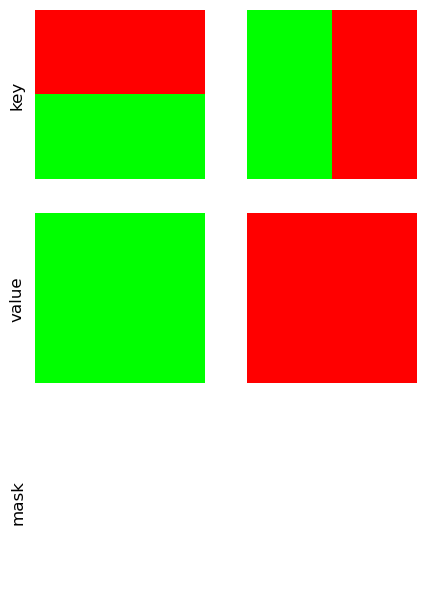

Seed: 0
Editing layer 1
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 39.84it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Found precomputed cov matrices, returning...
n_edit: 2
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([10, 14, 14])
vstar type: <class 'torch.Tensor'> shape: torch.Size([2, 20, 5, 5])
mstar type: <class 'torch.Tensor'> shape: torch.Size([2, 1, 32, 32])
key shape: torch.Size([2, 10, 14, 14]) val shape: torch.Size([2, 20, 5, 5])


tensor(2.8958, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 30000/30000 [00:39<00:00, 758.2


Loss (orig, final): 1.0704399347305298 2.8958418369293213
L2 norm of weight change: 645.2919311523438
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 41.47it/s]

Post-edit metrics: {'TP': array([ 63,  97, 217, 201, 281,  30,   0,   0,   0,  12]), 'TN': array([8051, 8360, 4941, 7063, 6039, 8255, 8592, 8489, 8576, 8535]), 'FPs': array([ 519,   55, 3577, 1477, 2529,  403,    0,   33,    0,    6]), 'FNs': array([867, 988, 765, 759, 651, 812, 908, 978, 924, 947]), 'accuracy': 0.0948421052631579, 'per_class_accuracy': array([0.85410526, 0.89021053, 0.54294737, 0.76463158, 0.66526316,
       0.87210526, 0.90442105, 0.89357895, 0.90273684, 0.89968421]), 'per_class_accuracy_mean': 0.8189684210526315, 'precision': array([0.10824742, 0.63815789, 0.05719557, 0.11978546, 0.1       ,
       0.06928406, 0.        , 0.        , 0.        , 0.66666667]), 'precision_mean': 0.1759337079584386, 'recall': array([0.06774194, 0.08940092, 0.2209776 , 0.209375  , 0.30150215,
       0.03562945, 0.        , 0.        , 0.        , 0.01251303]), 'recall_mean': 0.09371400878995029, 'predicted_class_distribution': array([ 582,  152, 3794, 1678, 2810,  433,    0,   33,    0,


/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


All metrics and KNN results can be found in saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_6/models
(0324_171908) Starting Trial 8/16...
saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_7
torch.Size([2, 1, 32, 32])
3 2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


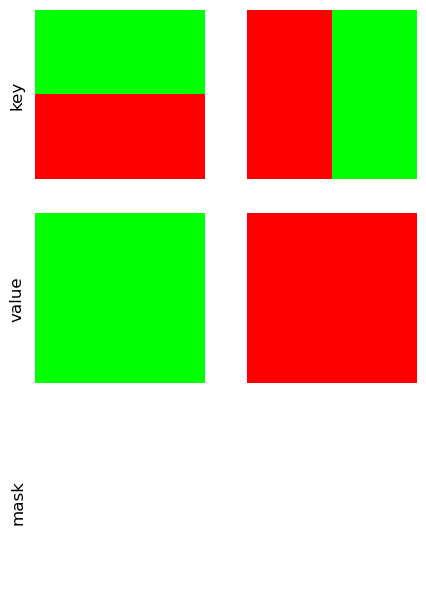

Seed: 0
Editing layer 1
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 39.74it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Found precomputed cov matrices, returning...
n_edit: 2
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([10, 14, 14])
vstar type: <class 'torch.Tensor'> shape: torch.Size([2, 20, 5, 5])
mstar type: <class 'torch.Tensor'> shape: torch.Size([2, 1, 32, 32])
key shape: torch.Size([2, 10, 14, 14]) val shape: torch.Size([2, 20, 5, 5])


tensor(0.6391, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 30000/30000 [00:40<00:00, 741.8


Loss (orig, final): 1.213748574256897 0.6390548348426819
L2 norm of weight change: 134.9217071533203
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 40.55it/s]

Post-edit metrics: {'TP': array([ 21, 175, 544, 255, 140,   4,   0,   0,   0,   0]), 'TN': array([8518, 8023, 4181, 6728, 6978, 8540, 8592, 8462, 8576, 8541]), 'FPs': array([  52,  392, 4337, 1812, 1590,  118,    0,   60,    0,    0]), 'FNs': array([909, 910, 438, 705, 792, 838, 908, 978, 924, 959]), 'accuracy': 0.11989473684210526, 'per_class_accuracy': array([0.89884211, 0.86294737, 0.49736842, 0.73505263, 0.74926316,
       0.89936842, 0.90442105, 0.89073684, 0.90273684, 0.89905263]), 'per_class_accuracy_mean': 0.823978947368421, 'precision': array([0.28767123, 0.30864198, 0.11145257, 0.1233672 , 0.08092486,
       0.03278689, 0.        , 0.        , 0.        , 0.        ]), 'precision_mean': 0.09448447189559098, 'recall': array([0.02258065, 0.16129032, 0.55397149, 0.265625  , 0.15021459,
       0.00475059, 0.        , 0.        , 0.        , 0.        ]), 'recall_mean': 0.11584326406025525, 'predicted_class_distribution': array([  73,  567, 4881, 2067, 1730,  122,    0,   60,    0


/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_8
torch.Size([2, 1, 32, 32])
3 2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


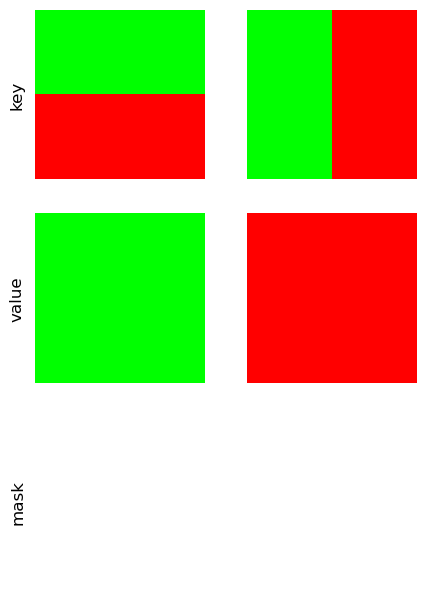

Seed: 0
Editing layer 1
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 39.68it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Found precomputed cov matrices, returning...
n_edit: 2
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([10, 14, 14])
vstar type: <class 'torch.Tensor'> shape: torch.Size([2, 20, 5, 5])
mstar type: <class 'torch.Tensor'> shape: torch.Size([2, 1, 32, 32])
key shape: torch.Size([2, 10, 14, 14]) val shape: torch.Size([2, 20, 5, 5])


tensor(0.9263, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 30000/30000 [00:39<00:00, 755.0

Loss (orig, final): 1.1861140727996826 0.9262608885765076
L2 norm of weight change: 284.195068359375
Performing post-edit metric calculations on validation set.



100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 40.00it/s]

Post-edit metrics: {'TP': array([  3,   0, 342, 128, 185,   7,   3,  25,  35,   1]), 'TN': array([8028, 8414, 2855, 7225, 7584, 8650, 8592, 8351, 8503, 8527]), 'FPs': array([ 542,    1, 5663, 1315,  984,    8,    0,  171,   73,   14]), 'FNs': array([ 927, 1085,  640,  832,  747,  835,  905,  953,  889,  958]), 'accuracy': 0.07673684210526316, 'per_class_accuracy': array([0.84536842, 0.88568421, 0.33652632, 0.774     , 0.81778947,
       0.91126316, 0.90473684, 0.88168421, 0.89873684, 0.89768421]), 'per_class_accuracy_mean': 0.8153473684210526, 'precision': array([0.00550459, 0.        , 0.05695254, 0.08870409, 0.15825492,
       0.46666667, 1.        , 0.12755102, 0.32407407, 0.06666667]), 'precision_mean': 0.22943745619599584, 'recall': array([0.00322581, 0.        , 0.34826884, 0.13333333, 0.19849785,
       0.00831354, 0.00330396, 0.02556237, 0.03787879, 0.00104275]), 'recall_mean': 0.07594272498506746, 'predicted_class_distribution': array([ 545,    1, 6005, 1443, 1169,   15,    3,


/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Saved post-edit logits to saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_8/models/post_edit_logits.pth
All metrics and KNN results can be found in saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_8/models
(0324_172032) Starting Trial 10/16...
saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_9
torch.Size([2, 1, 32, 32])
3 2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


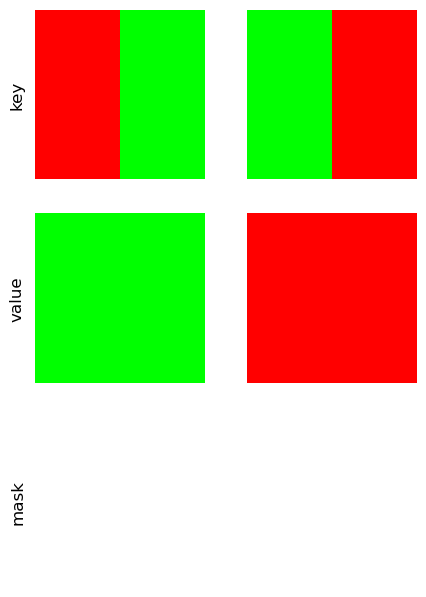

Seed: 0
Editing layer 1
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 39.04it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Found precomputed cov matrices, returning...
n_edit: 2
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([10, 14, 14])
vstar type: <class 'torch.Tensor'> shape: torch.Size([2, 20, 5, 5])
mstar type: <class 'torch.Tensor'> shape: torch.Size([2, 1, 32, 32])
key shape: torch.Size([2, 10, 14, 14]) val shape: torch.Size([2, 20, 5, 5])


tensor(0.7701, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 30000/30000 [00:39<00:00, 767.7

Loss (orig, final): 0.9742887020111084 0.7700714468955994
L2 norm of weight change: 5.081810474395752
Performing post-edit metric calculations on validation set.



100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 40.07it/s]

Post-edit metrics: {'TP': array([450, 538, 519, 496, 452, 422, 438, 472, 455, 449]), 'TN': array([8272, 8313, 8190, 7662, 7801, 8249, 8161, 8254, 7757, 8032]), 'FPs': array([298, 102, 328, 878, 767, 409, 431, 268, 819, 509]), 'FNs': array([480, 547, 463, 464, 480, 420, 470, 506, 469, 510]), 'accuracy': 0.4937894736842105, 'per_class_accuracy': array([0.91810526, 0.93168421, 0.91673684, 0.85873684, 0.86873684,
       0.91273684, 0.90515789, 0.91852632, 0.86442105, 0.89273684]), 'per_class_accuracy_mean': 0.8987578947368421, 'precision': array([0.60160428, 0.840625  , 0.61275089, 0.36098981, 0.37079573,
       0.5078219 , 0.50402762, 0.63783784, 0.35714286, 0.46868476]), 'precision_mean': 0.5262280682705425, 'recall': array([0.48387097, 0.49585253, 0.52851324, 0.51666667, 0.48497854,
       0.50118765, 0.48237885, 0.48261759, 0.49242424, 0.46819604]), 'recall_mean': 0.49366863179895704, 'predicted_class_distribution': array([ 748,  640,  847, 1374, 1219,  831,  869,  740, 1274,  958]), '

saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_10
torch.Size([2, 1, 32, 32])
3 2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


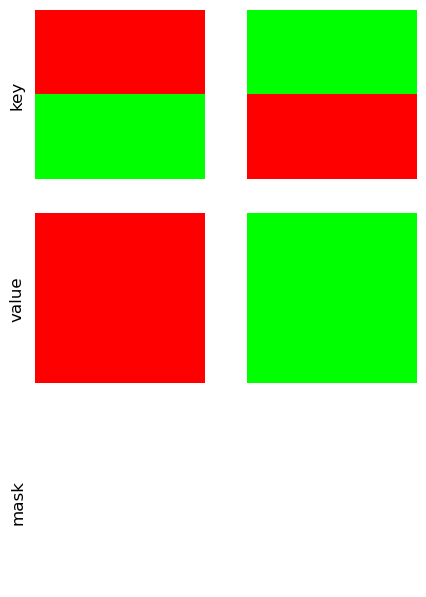

Seed: 0
Editing layer 1
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 40.15it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Saved pre-edit logits to saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_10/models/pre_edit_logits.pth
Created <class 'trainer.editor.EditorEAC'> editor.
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/2_Spurious_MNIST_hold_out/lenet-1
Found precomputed cov matrices, returning...
n_edit: 2
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([10, 14, 14])
vstar type: <class 'torch.Tensor'> shape: torch.Size([2, 20, 5, 5])
mstar type: <class 'torch.Tensor'> shape: torch.Size([2, 1, 32, 32])
key shape: torch.Size([2, 10, 14, 14]) val shape: torch.Size([2, 20, 5, 5])


tensor(1.1076, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 30000/30000 [00:37<00:00, 792.8


Loss (orig, final): 1.390702247619629 1.1076252460479736
L2 norm of weight change: 3.7443559169769287
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 41.81it/s]

Post-edit metrics: {'TP': array([450, 538, 520, 497, 452, 421, 429, 469, 456, 453]), 'TN': array([8245, 8300, 8225, 7757, 7730, 8339, 8482, 8353, 7296, 7958]), 'FPs': array([ 325,  115,  293,  783,  838,  319,  110,  169, 1280,  583]), 'FNs': array([480, 547, 462, 463, 480, 421, 479, 509, 468, 506]), 'accuracy': 0.49315789473684213, 'per_class_accuracy': array([0.91526316, 0.93031579, 0.92052632, 0.86884211, 0.86126316,
       0.92210526, 0.938     , 0.92863158, 0.816     , 0.88536842]), 'per_class_accuracy_mean': 0.8986315789473686, 'precision': array([0.58064516, 0.82388974, 0.6396064 , 0.38828125, 0.3503876 ,
       0.56891892, 0.79591837, 0.73510972, 0.26267281, 0.43725869]), 'precision_mean': 0.5582688646369393, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.5       , 0.47246696, 0.4795501 , 0.49350649, 0.47236705]), 'recall_mean': 0.4929832549755909, 'predicted_class_distribution': array([ 775,  653,  813, 1280, 1290,  740,  539,  638, 1736,

Saved post-edit metrics saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_10/models/post_edit_metrics.pth
Saved post-edit logits to saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_10/models/post_edit_logits.pth
All metrics and KNN results can be found in saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_10/models
(0324_172154) Starting Trial 12/16...
saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_11
torch.Size([2, 1, 32, 32])
3 2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB 

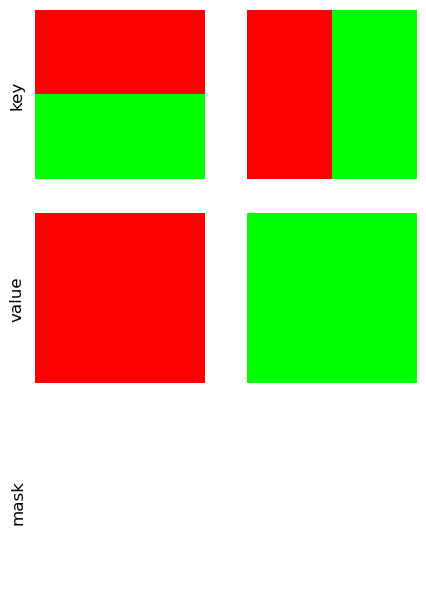

Seed: 0
Editing layer 1
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 40.75it/s]


Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

tensor(0.9284, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 30000/30000 [00:39<00:00, 758.6

Loss (orig, final): 1.1788768768310547 0.9283984899520874
L2 norm of weight change: 253.84030151367188
Performing post-edit metric calculations on validation set.



100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 40.25it/s]

Post-edit metrics: {'TP': array([476, 201, 422,  76, 719,  17,   2,  11,   7,   1]), 'TN': array([7550, 8356, 8129, 8488, 3133, 8264, 8580, 8478, 8454, 8500]), 'FPs': array([1020,   59,  389,   52, 5435,  394,   12,   44,  122,   41]), 'FNs': array([454, 884, 560, 884, 213, 825, 906, 967, 917, 958]), 'accuracy': 0.2033684210526316, 'per_class_accuracy': array([0.84484211, 0.90073684, 0.90010526, 0.90147368, 0.40547368,
       0.87168421, 0.90336842, 0.89357895, 0.89063158, 0.89484211]), 'per_class_accuracy_mean': 0.8406736842105265, 'precision': array([0.31818182, 0.77307692, 0.52034525, 0.59375   , 0.11683458,
       0.04136253, 0.14285714, 0.2       , 0.05426357, 0.02380952]), 'precision_mean': 0.278448133614038, 'recall': array([0.51182796, 0.18525346, 0.42973523, 0.07916667, 0.77145923,
       0.02019002, 0.00220264, 0.01124744, 0.00757576, 0.00104275]), 'recall_mean': 0.2019701162691694, 'predicted_class_distribution': array([1496,  260,  811,  128, 6154,  411,   14,   55,  129,  

saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_12
torch.Size([2, 1, 32, 32])
3 2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


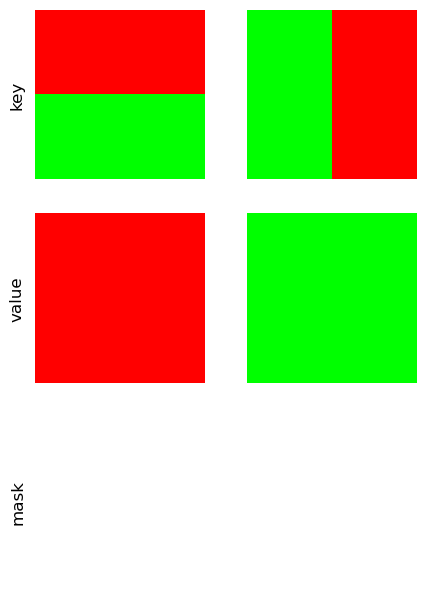

Seed: 0
Editing layer 1
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 40.76it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Found precomputed cov matrices, returning...
n_edit: 2
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([10, 14, 14])
vstar type: <class 'torch.Tensor'> shape: torch.Size([2, 20, 5, 5])
mstar type: <class 'torch.Tensor'> shape: torch.Size([2, 1, 32, 32])
key shape: torch.Size([2, 10, 14, 14]) val shape: torch.Size([2, 20, 5, 5])


tensor(2.2029, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 30000/30000 [00:39<00:00, 758.4

Loss (orig, final): 0.9987020492553711 2.202908992767334
L2 norm of weight change: 469.6293029785156
Performing post-edit metric calculations on validation set.



100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 40.17it/s]

Post-edit metrics: {'TP': array([ 49,  86, 167, 391,  76,  39,   0,   0,   0,  18]), 'TN': array([8022, 8292, 5927, 4212, 8134, 8056, 8591, 8493, 8576, 8523]), 'FPs': array([ 548,  123, 2591, 4328,  434,  602,    1,   29,    0,   18]), 'FNs': array([881, 999, 815, 569, 856, 803, 908, 978, 924, 941]), 'accuracy': 0.08694736842105263, 'per_class_accuracy': array([0.84957895, 0.88189474, 0.64147368, 0.48452632, 0.86421053,
       0.85210526, 0.90431579, 0.894     , 0.90273684, 0.89905263]), 'per_class_accuracy_mean': 0.8173894736842104, 'precision': array([0.08207705, 0.41148325, 0.06055112, 0.08285654, 0.14901961,
       0.06084243, 0.        , 0.        , 0.        , 0.5       ]), 'precision_mean': 0.13468300084601928, 'recall': array([0.05268817, 0.07926267, 0.1700611 , 0.40729167, 0.08154506,
       0.04631829, 0.        , 0.        , 0.        , 0.01876955]), 'recall_mean': 0.08559365170972441, 'predicted_class_distribution': array([ 597,  209, 2758, 4719,  510,  641,    1,   29,    


/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_13
torch.Size([2, 1, 32, 32])
3 2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


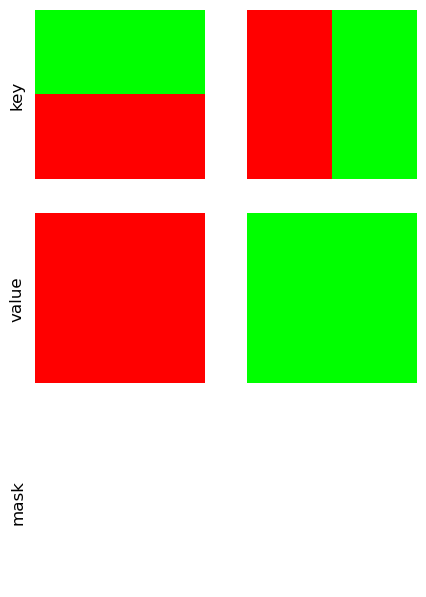

Seed: 0
Editing layer 1
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 39.55it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Found precomputed cov matrices, returning...
n_edit: 2
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([10, 14, 14])
vstar type: <class 'torch.Tensor'> shape: torch.Size([2, 20, 5, 5])
mstar type: <class 'torch.Tensor'> shape: torch.Size([2, 1, 32, 32])
key shape: torch.Size([2, 10, 14, 14]) val shape: torch.Size([2, 20, 5, 5])


tensor(0.6934, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 30000/30000 [00:39<00:00, 764.4

Loss (orig, final): 1.2443348169326782 0.6933825016021729
L2 norm of weight change: 89.55833435058594
Performing post-edit metric calculations on validation set.



100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 39.89it/s]

Post-edit metrics: {'TP': array([ 74, 263, 561, 254, 233,  20,   0,   1,   0,   0]), 'TN': array([8374, 7567, 4685, 7526, 6487, 8602, 8592, 8457, 8576, 8540]), 'FPs': array([ 196,  848, 3833, 1014, 2081,   56,    0,   65,    0,    1]), 'FNs': array([856, 822, 421, 706, 699, 822, 908, 977, 924, 959]), 'accuracy': 0.148, 'per_class_accuracy': array([0.88926316, 0.82421053, 0.55221053, 0.81894737, 0.70736842,
       0.90757895, 0.90442105, 0.89031579, 0.90273684, 0.89894737]), 'per_class_accuracy_mean': 0.8296000000000001, 'precision': array([0.27407407, 0.23672367, 0.1276741 , 0.20031546, 0.10069144,
       0.26315789, 0.        , 0.01515152, 0.        , 0.        ]), 'precision_mean': 0.1217788158177872, 'recall': array([0.07956989, 0.24239631, 0.5712831 , 0.26458333, 0.25      ,
       0.02375297, 0.        , 0.00102249, 0.        , 0.        ]), 'recall_mean': 0.14326080989021867, 'predicted_class_distribution': array([ 270, 1111, 4394, 1268, 2314,   76,    0,   66,    0,    1]), 'f1'


/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_14
torch.Size([2, 1, 32, 32])
3 2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


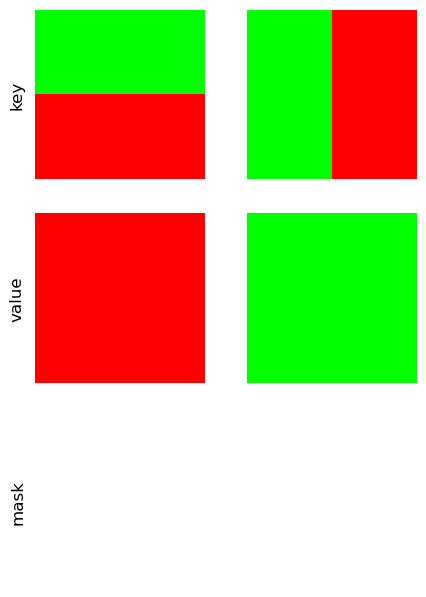

Seed: 0
Editing layer 1
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 39.37it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Found precomputed cov matrices, returning...
n_edit: 2
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([10, 14, 14])
vstar type: <class 'torch.Tensor'> shape: torch.Size([2, 20, 5, 5])
mstar type: <class 'torch.Tensor'> shape: torch.Size([2, 1, 32, 32])
key shape: torch.Size([2, 10, 14, 14]) val shape: torch.Size([2, 20, 5, 5])


tensor(0.8452, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 30000/30000 [00:39<00:00, 752.4


Loss (orig, final): 1.064159870147705 0.8451864123344421
L2 norm of weight change: 178.51959228515625
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 39.25it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([  2,   1, 659,  59,  57,   0,   0,  30,   0,   0]), 'TN': array([8502, 8409, 1751, 7354, 7972, 8657, 8592, 8454, 8576, 8541]), 'FPs': array([  68,    6, 6767, 1186,  596,    1,    0,   68,    0,    0]), 'FNs': array([ 928, 1084,  323,  901,  875,  842,  908,  948,  924,  959]), 'accuracy': 0.08505263157894737, 'per_class_accuracy': array([0.89515789, 0.88526316, 0.25368421, 0.78031579, 0.84515789,
       0.91126316, 0.90442105, 0.89305263, 0.90273684, 0.89905263]), 'per_class_accuracy_mean': 0.8170105263157895, 'precision': array([0.02857143, 0.14285714, 0.08874226, 0.04738956, 0.08728943,
       0.        , 0.        , 0.30612245, 0.        , 0.        ]), 'precision_mean': 0.07009722689605677, 'recall': array([0.00215054, 0.00092166, 0.67107943, 0.06145833, 0.0611588 ,
       0.        , 0.        , 0.03067485, 0.        , 0.        ]), 'recall_mean': 0.08274436045981799, 'predicted_class_distribution': array([  70,    7, 7426, 1245,  653,    1,    0,

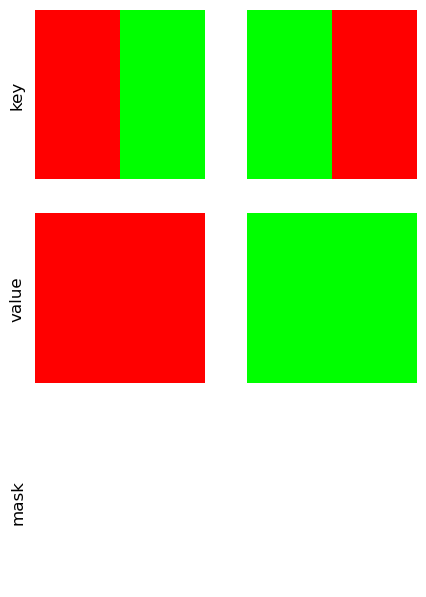

Seed: 0
Editing layer 1
Created ModelWrapperSanturkar model with 31340 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-LeNet/0323_100223/models/model_best.pth
Using passed in data loader for validation.
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 39.20it/s]

Pre-edit metrics: {'TP': array([450, 538, 520, 497, 452, 422, 436, 472, 456, 453]), 'TN': array([8250, 8296, 8225, 7702, 7784, 8342, 8397, 8265, 7467, 7968]), 'FPs': array([ 320,  119,  293,  838,  784,  316,  195,  257, 1109,  573]), 'FNs': array([480, 547, 462, 463, 480, 420, 472, 506, 468, 506]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.91578947, 0.92989474, 0.92052632, 0.86305263, 0.86694737,
       0.92252632, 0.92978947, 0.91968421, 0.834     , 0.88642105]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.58441558, 0.81887367, 0.6396064 , 0.37228464, 0.36569579,
       0.57181572, 0.69096672, 0.64746228, 0.2913738 , 0.44152047]), 'precision_mean': 0.5424015070238444, 'recall': array([0.48387097, 0.49585253, 0.52953157, 0.51770833, 0.48497854,
       0.50118765, 0.48017621, 0.48261759, 0.49350649, 0.47236705]), 'recall_mean': 0.4941796933975864, 'predicted_class_distribution': array([ 770,  657,  813, 1335, 1236,  738,  631,  729, 1565, 1

Found precomputed cov matrices, returning...
n_edit: 2
Forwarded edit data thru model
Kstar[0] type: <class 'torch.Tensor'> shape: torch.Size([10, 14, 14])
vstar type: <class 'torch.Tensor'> shape: torch.Size([2, 20, 5, 5])
mstar type: <class 'torch.Tensor'> shape: torch.Size([2, 1, 32, 32])
key shape: torch.Size([2, 10, 14, 14]) val shape: torch.Size([2, 20, 5, 5])


tensor(0.8636, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 30000/30000 [00:36<00:00, 833.0

Loss (orig, final): 0.8217484951019287 0.8636015057563782
L2 norm of weight change: 5.838578224182129
Performing post-edit metric calculations on validation set.



100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 38.62it/s]

Post-edit metrics: {'TP': array([450, 537, 519, 494, 450, 416, 427, 471, 455, 457]), 'TN': array([8262, 8293, 8170, 7739, 7786, 8349, 8480, 8266, 7438, 7893]), 'FPs': array([ 308,  122,  348,  801,  782,  309,  112,  256, 1138,  648]), 'FNs': array([480, 548, 463, 466, 482, 426, 481, 507, 469, 502]), 'accuracy': 0.4922105263157895, 'per_class_accuracy': array([0.91705263, 0.92947368, 0.91463158, 0.86663158, 0.86694737,
       0.92263158, 0.93757895, 0.91968421, 0.83084211, 0.87894737]), 'per_class_accuracy_mean': 0.8984421052631578, 'precision': array([0.59366755, 0.81487102, 0.59861592, 0.38146718, 0.36525974,
       0.5737931 , 0.79220779, 0.64786795, 0.28562461, 0.41357466]), 'precision_mean': 0.5466949515977528, 'recall': array([0.48387097, 0.49493088, 0.52851324, 0.51458333, 0.48283262,
       0.49406176, 0.47026432, 0.48159509, 0.49242424, 0.47653806]), 'recall_mean': 0.49196145027950433, 'predicted_class_distribution': array([ 758,  659,  867, 1295, 1232,  725,  539,  727, 1593,

In [54]:
iv_path = 'layernum'
iv_values = [0, 1]
print("Varying {} with following values: {}".format(iv_path, iv_values))

run_experiments(
    iv_path=iv_path,
    iv_values=iv_values,
    edit_data_loader=edit_data_loader,
    progress_report_path=progress_report_path,
    trial_paths_path=trial_paths_path,
    timestamp=timestamp,
    config_dict=config_dict,
    covariance_data_loader=covariance_data_loader,
    test_data_loader=test_data_loader,
    analyze_in_edit=True,
    debug=True,
    seed=0)